# Simulated Data Benchmark

## Importing necessary libraries

In [4]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
BASE_DIR = r"E:\Project_Research\CauFinder_Project\CauFinder-master"
save_path = os.path.join(BASE_DIR, "benchmark", "output", "bm_simData_lin")
sys.path.append(BASE_DIR)
from CauFinder.benchmark import run_benchmark


## Benchmark main function

In [5]:
def benchmark_main(
        noises,
        causal_strengths,
        save_path,
        n_dataset=10,
        method_for_threshold="cumulative_rate",
        is_linear=False
):
    #%%
    evaluate_scores = []
    benchmark_results = []
    for i, noise in enumerate(noises):
        for j, causal_strength in enumerate(causal_strengths):
            print(f"noise:{noise}; causal_strength:{causal_strength}")
            evaluate_res, benchmark_res = run_benchmark(
                # simulation parameters
                n_dataset=n_dataset,
                noise_level=noise,
                causal_strength=causal_strength,
                is_linear=is_linear,
                activation="relu",
                # model parameters
                n_latent=10,
                n_hidden=64,
                n_layers_encoder=0,
                n_layers_decoder=0,
                n_layers_dpd=0,
                dropout_rate_encoder=0.0,
                dropout_rate_decoder=0.0,
                dropout_rate_dpd=0.0,
                use_batch_norm='none',
                use_batch_norm_dpd=True,
                pdp_linear=True,
                # eva parameters
                threshold_method=method_for_threshold,
                save_path=save_path)
            evaluate_scores.append(evaluate_res)
            benchmark_results.append(benchmark_res)
    #%%
    plt.rcParams.update({
        'font.size': 12,
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'axes.linewidth': 1.2,
        'grid.linewidth': 0.5,
        'font.sans-serif': ['Arial'],
        'font.family': 'sans-serif'
    })

    metrics_list = ['AUC', 'ACC', 'MCC', 'Precision', 'Specificity', 'Recall', 'F1_score', 'num_w_cum_rate']
    # metrics_list = ['AUC', 'ACC', 'MCC', 'Specificity', 'Recall', 'F1_score', 'num_w_cum_rate']
    for method in metrics_list:
        fig, axs = plt.subplots(len(noises), len(causal_strengths),
                                figsize=(len(causal_strengths) * 5, len(noises) * 5))

        # Ensure axs is always a 2D array for consistent indexing
        if len(noises) == 1 and len(causal_strengths) == 1:
            axs = np.array([[axs]])
        elif len(noises) == 1:
            axs = axs[np.newaxis, :]  # Add a new axis to make it 2D
        elif len(causal_strengths) == 1:
            axs = axs[:, np.newaxis]  # Add a new axis to make it 2D

        for i, res in enumerate(evaluate_scores):
            x, y = divmod(i, len(causal_strengths))
            ax = axs[x, y] if len(noises) > 1 or len(causal_strengths) > 1 else axs[0]

            sns.boxplot(data=res[f'{method}'].iloc[:, :n_dataset].T, ax=ax, palette='Set2')
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_title(f'Noise: {noises[x]} | Causal Strengths: {causal_strengths[y]}', fontsize=14, pad=10)
            if method != 'num_w_cum_rate':
                if method == 'AUC':
                    ax.set_ylim(0, 1.0)
                else:
                    ax.set_ylim(0, 1.0)
            ax.grid(True)
        plt.tight_layout()
        fig.subplots_adjust(top=0.93)
        fig.suptitle(f"Comparison of {method} Values for Different Methods", fontsize=16)
        # plt.savefig(os.path.join(save_path, f'{method}_boxplot.png'), format='png')
        # plt.savefig(os.path.join(save_path, f'{method}_boxplot.pdf'), format='pdf')
        plt.show()
        # plt.close()

    # Generating radar chart for the mean values of each metric for different methods
    def create_mean_radar_chart(evaluate_scores, metrics_list, save_path):
        # Retrieve the list of method names
        method_names = evaluate_scores[0][metrics_list[0]].index.tolist()
        mean_values = {method: [] for method in method_names}

        # Calculate mean values for each method
        for metric in metrics_list:
            if metric == "num_w_cum_rate":
                continue  # Skip num_w_cum_rate
            print(f"Processing metric: {metric}")  # Debug: Print current metric
            for method_name in method_names:
                all_values = []
                for res in evaluate_scores:
                    value = res[metric].loc[method_name, 'Mean']
                    all_values.append(value)
                mean_val = np.mean(all_values)
                mean_values[method_name].append(mean_val)

        # Define the categories excluding "num_w_cum_rate"
        categories = [metric for metric in metrics_list if metric != "num_w_cum_rate"]
        num_categories = len(categories)

        # Calculate angles for each category
        angles = [n / float(num_categories) * 2 * np.pi for n in range(num_categories)]
        angles += angles[:1]

        # Create radar chart
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot and fill for each method
        for method_name in method_names:
            values = mean_values[method_name]
            print(
                f"{method_name} values length: {len(values)}, num_categories: {num_categories}")  # Debug: Print lengths
            if len(values) != num_categories:
                print(f"Skipping {method_name} due to mismatch in number of categories.")
                continue
            values += values[:1]

            # Debug: Print values before plotting
            print(f"Plotting {method_name}: {values}")

            ax.plot(angles, values, linewidth=2, linestyle='solid', label=method_name)
            ax.fill(angles, values, alpha=0.25)

        # Remove y-axis labels
        # ax.set_yticklabels([])

        # Add numbers to the circles
        ax.set_rlabel_position(0)
        ax.yaxis.set_tick_params(labelsize=10)

        # Set x-ticks and labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=12)

        # Configure legend
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)

        # Save the chart as PDF and PNG
        # plt.savefig(os.path.join(save_path, "mean_radar_chart.pdf"), format="pdf", bbox_inches='tight')
        # plt.savefig(os.path.join(save_path, "mean_radar_chart.png"), format="png", bbox_inches='tight')
        plt.show()
        # plt.close()

    create_mean_radar_chart(evaluate_scores, metrics_list, save_path)

    return evaluate_scores, benchmark_results


## Run benchmark

The dtype argument is deprecated and will be removed in late 2024.


noise:0.01; causal_strength:2
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.86it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 2/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.85it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.74it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.56it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.69it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 11.01it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.58it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.60it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:39<00:00,  7.64it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.95it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


noise:0.01; causal_strength:4
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.30it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 2/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.56it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.97it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  9.06it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.35it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  9.02it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.77it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.39it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.73it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.92it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


noise:0.01; causal_strength:6
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.97it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 2/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:36<00:00,  8.22it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:35<00:00,  8.51it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:29<00:00, 10.14it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.82it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.37it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.33it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.75it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.55it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.95it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


noise:0.1; causal_strength:2
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:29<00:00, 10.01it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 2/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.90it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.92it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.45it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:29<00:00, 10.18it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.28it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.72it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.90it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.52it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.93it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


noise:0.1; causal_strength:4
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.82it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 2/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.51it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.44it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.68it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.17it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.38it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.90it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.59it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.92it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.53it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


noise:0.1; causal_strength:6
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.15it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 2/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.86it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.69it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  8.91it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.17it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:33<00:00,  9.04it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.86it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.77it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.32it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.31it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


noise:1.0; causal_strength:2
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.30it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 2/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.77it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.66it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.94it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.98it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.90it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.83it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.73it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.63it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.33it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


noise:1.0; causal_strength:4
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.45it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 2/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.94it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.37it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.87it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.14it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.63it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.29it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.91it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.43it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.36it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


noise:1.0; causal_strength:6
This is the 1/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.86it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


This is the 2/10 dataset


The dtype argument is deprecated and will be removed in late 2024.
training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.97it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 3/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.39it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 4/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.71it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 5/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.36it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 6/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.76it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 7/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.74it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 8/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.54it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 9/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 11.10it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The dtype argument is deprecated and will be removed in late 2024.


This is the 10/10 dataset


training: 100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.15it/s]
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


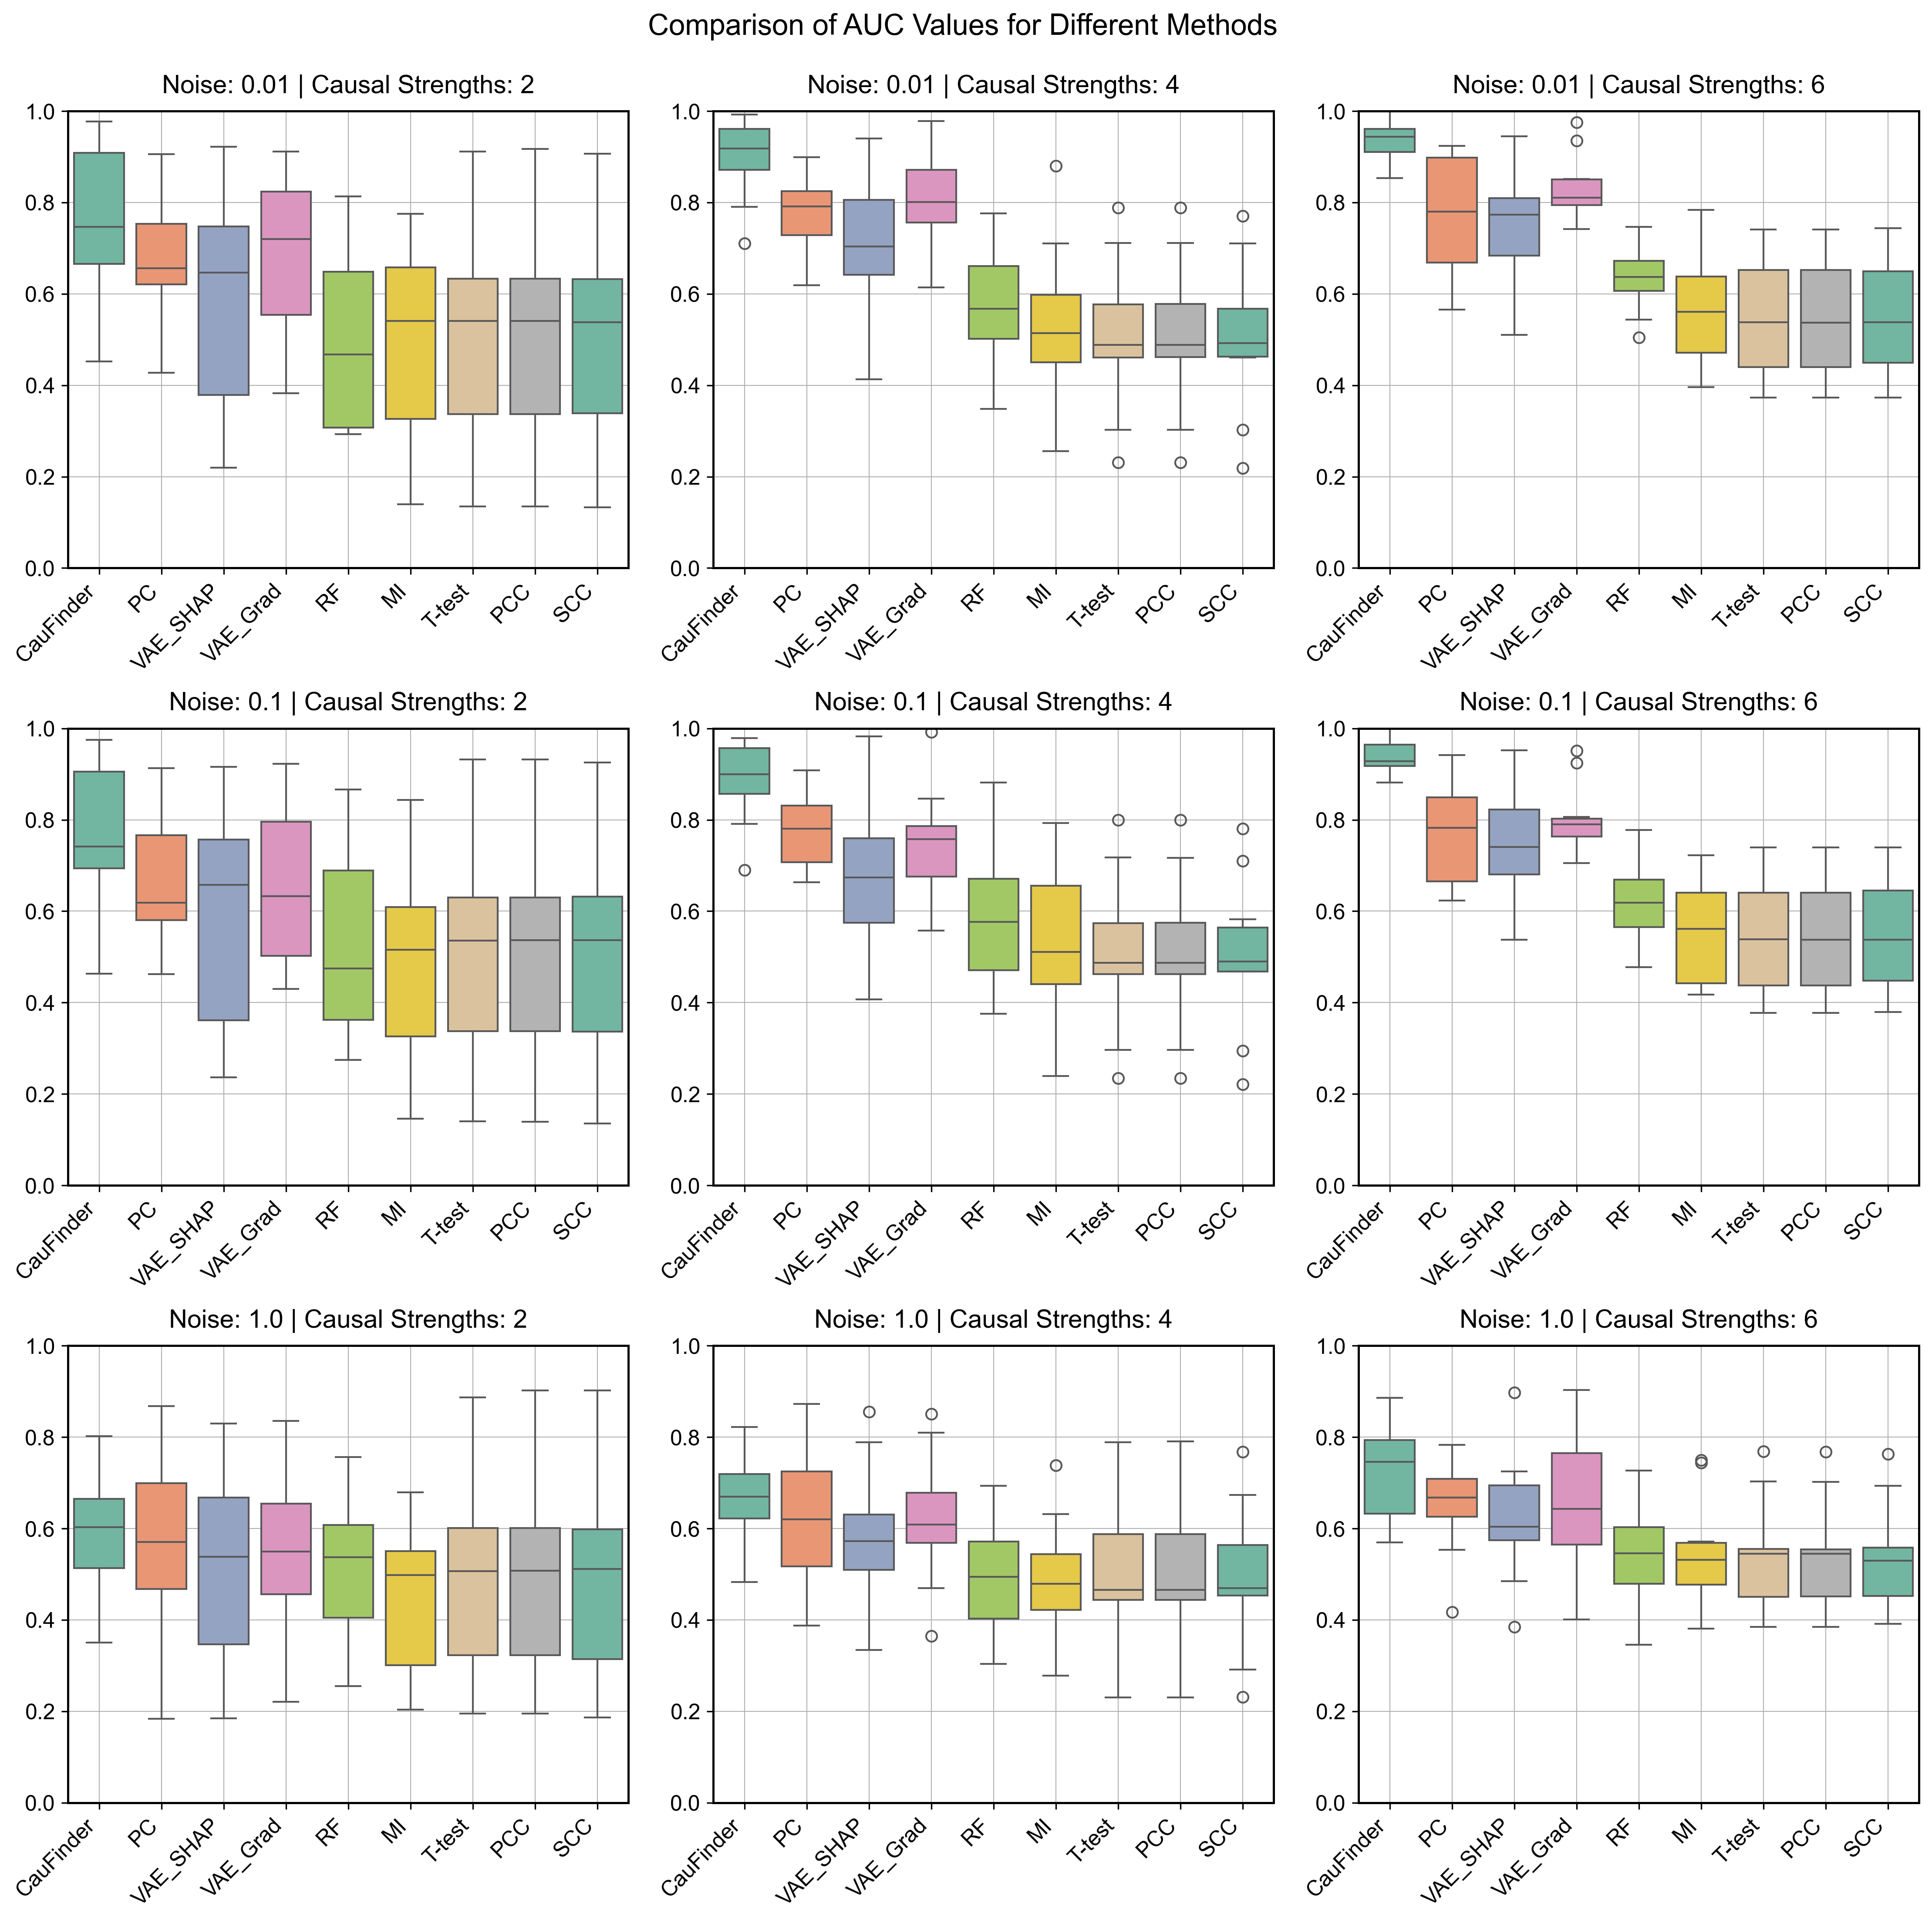

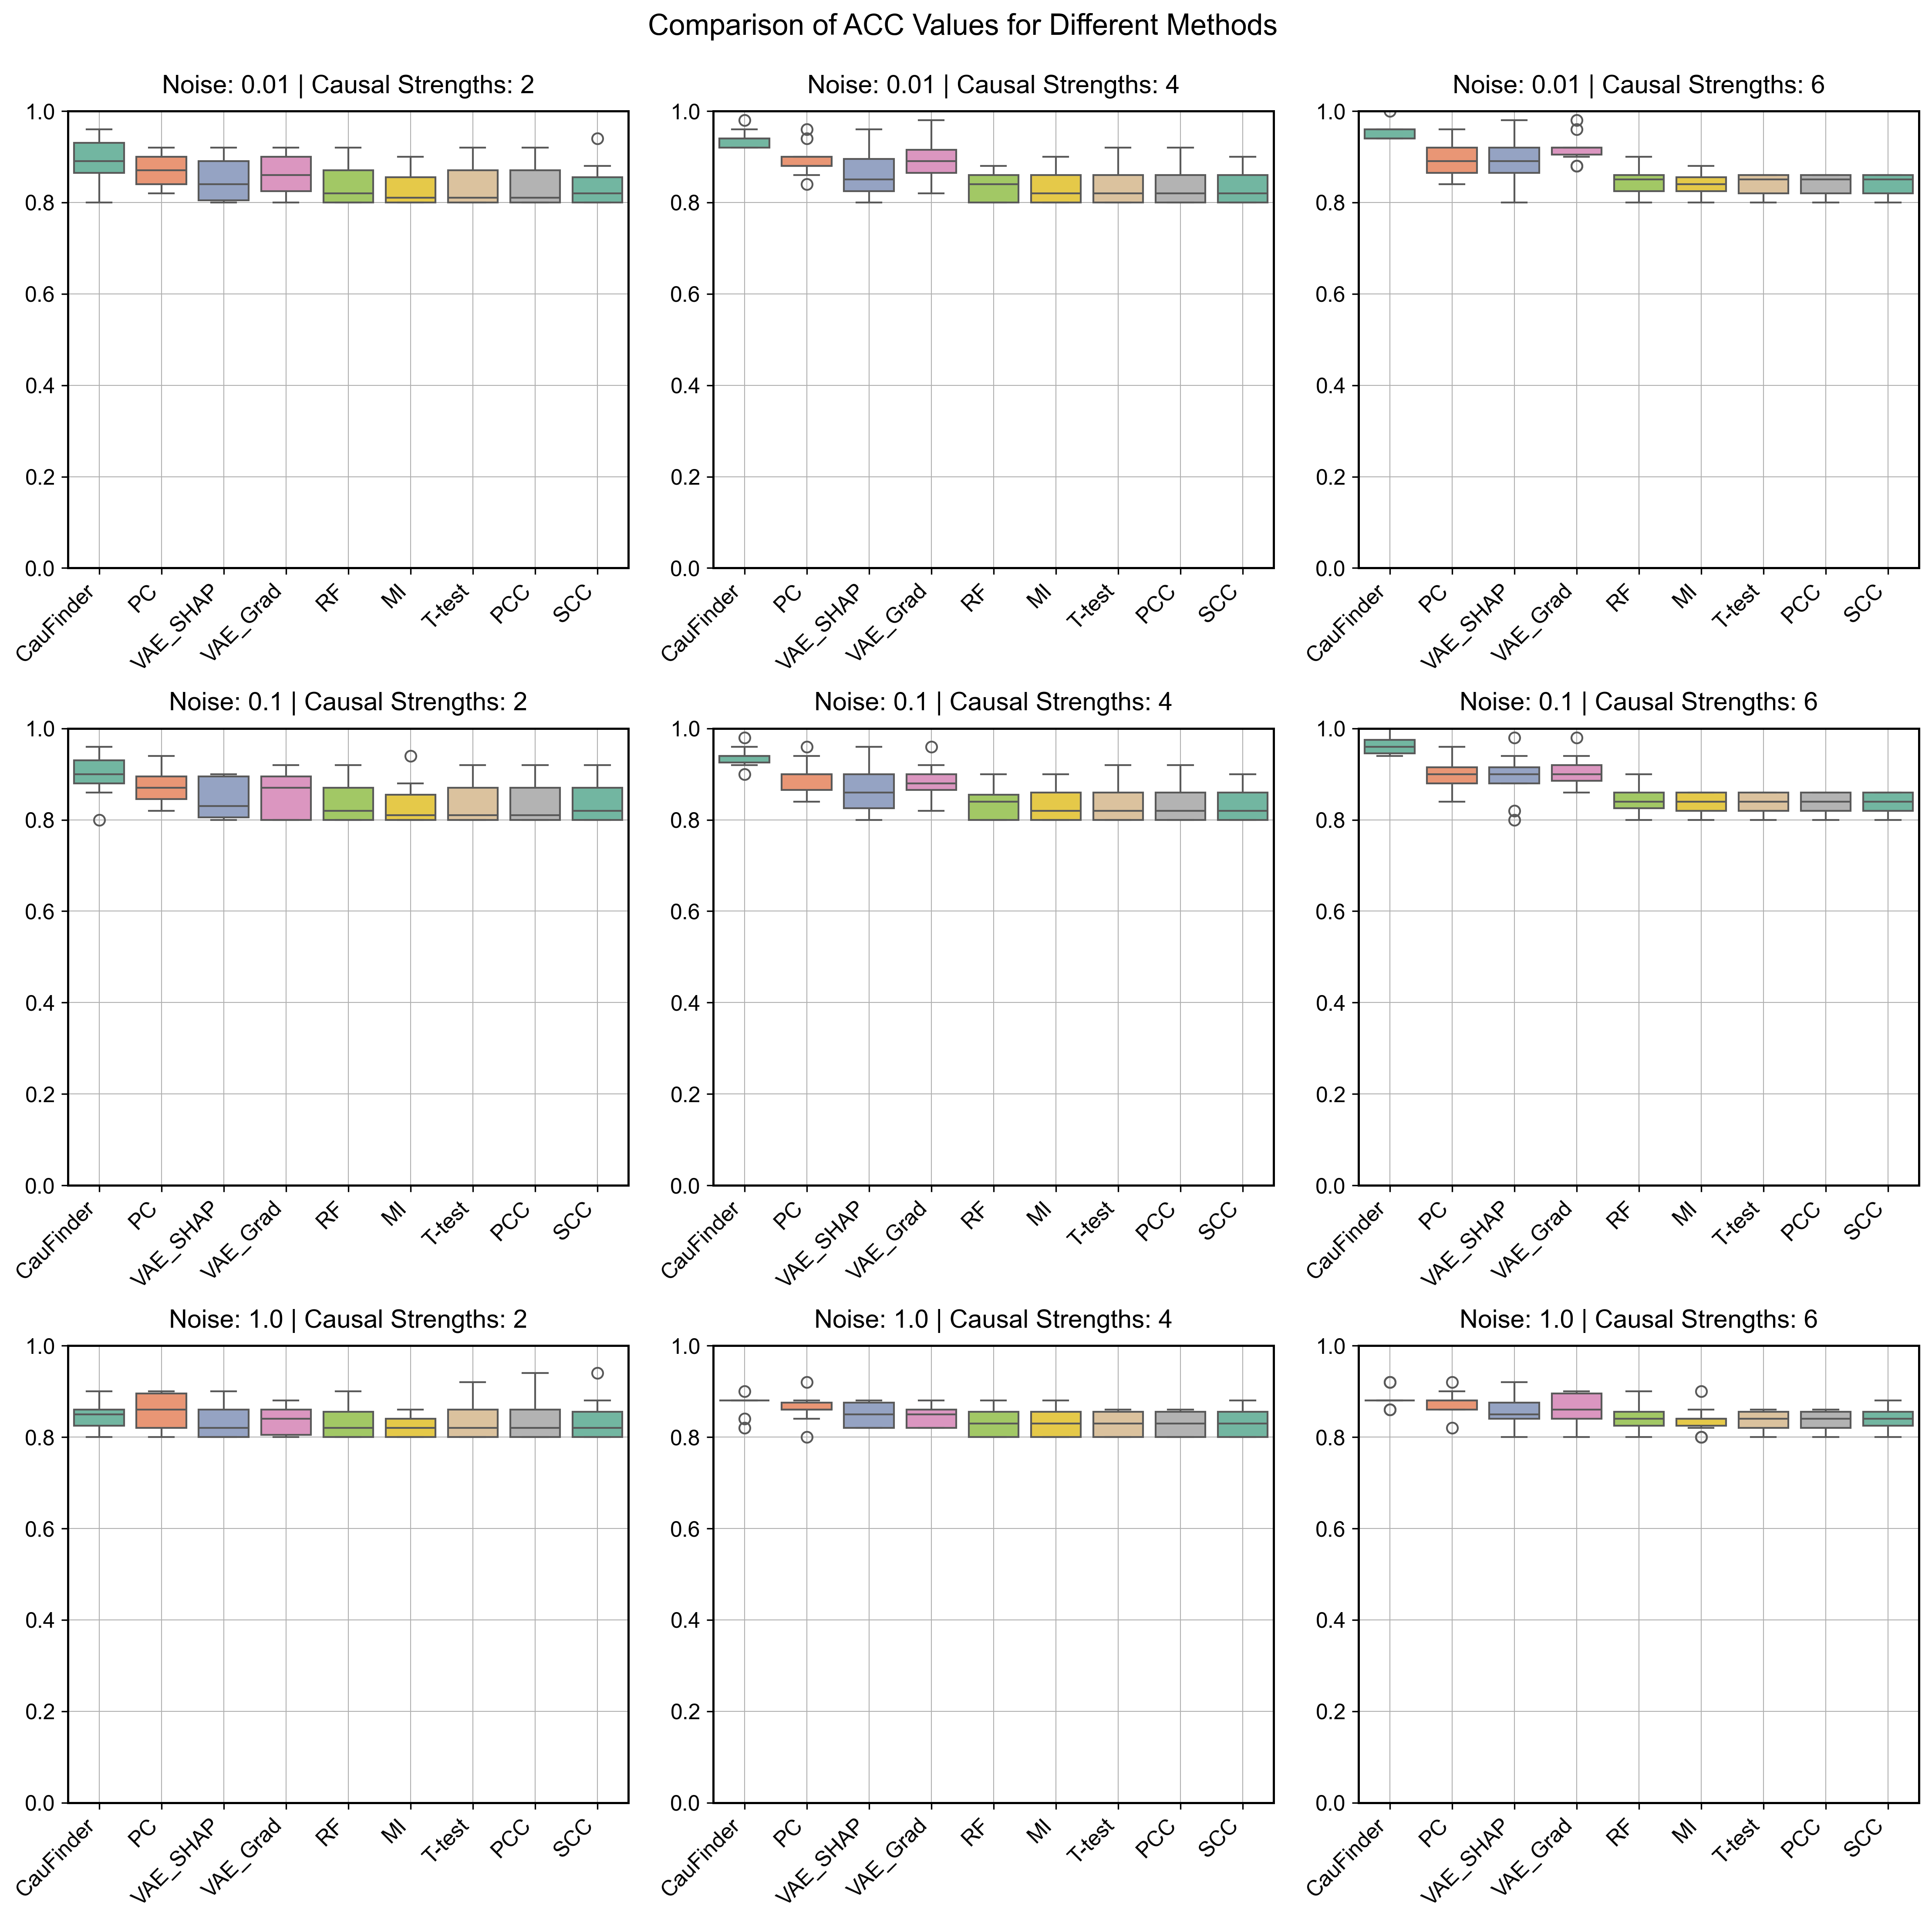

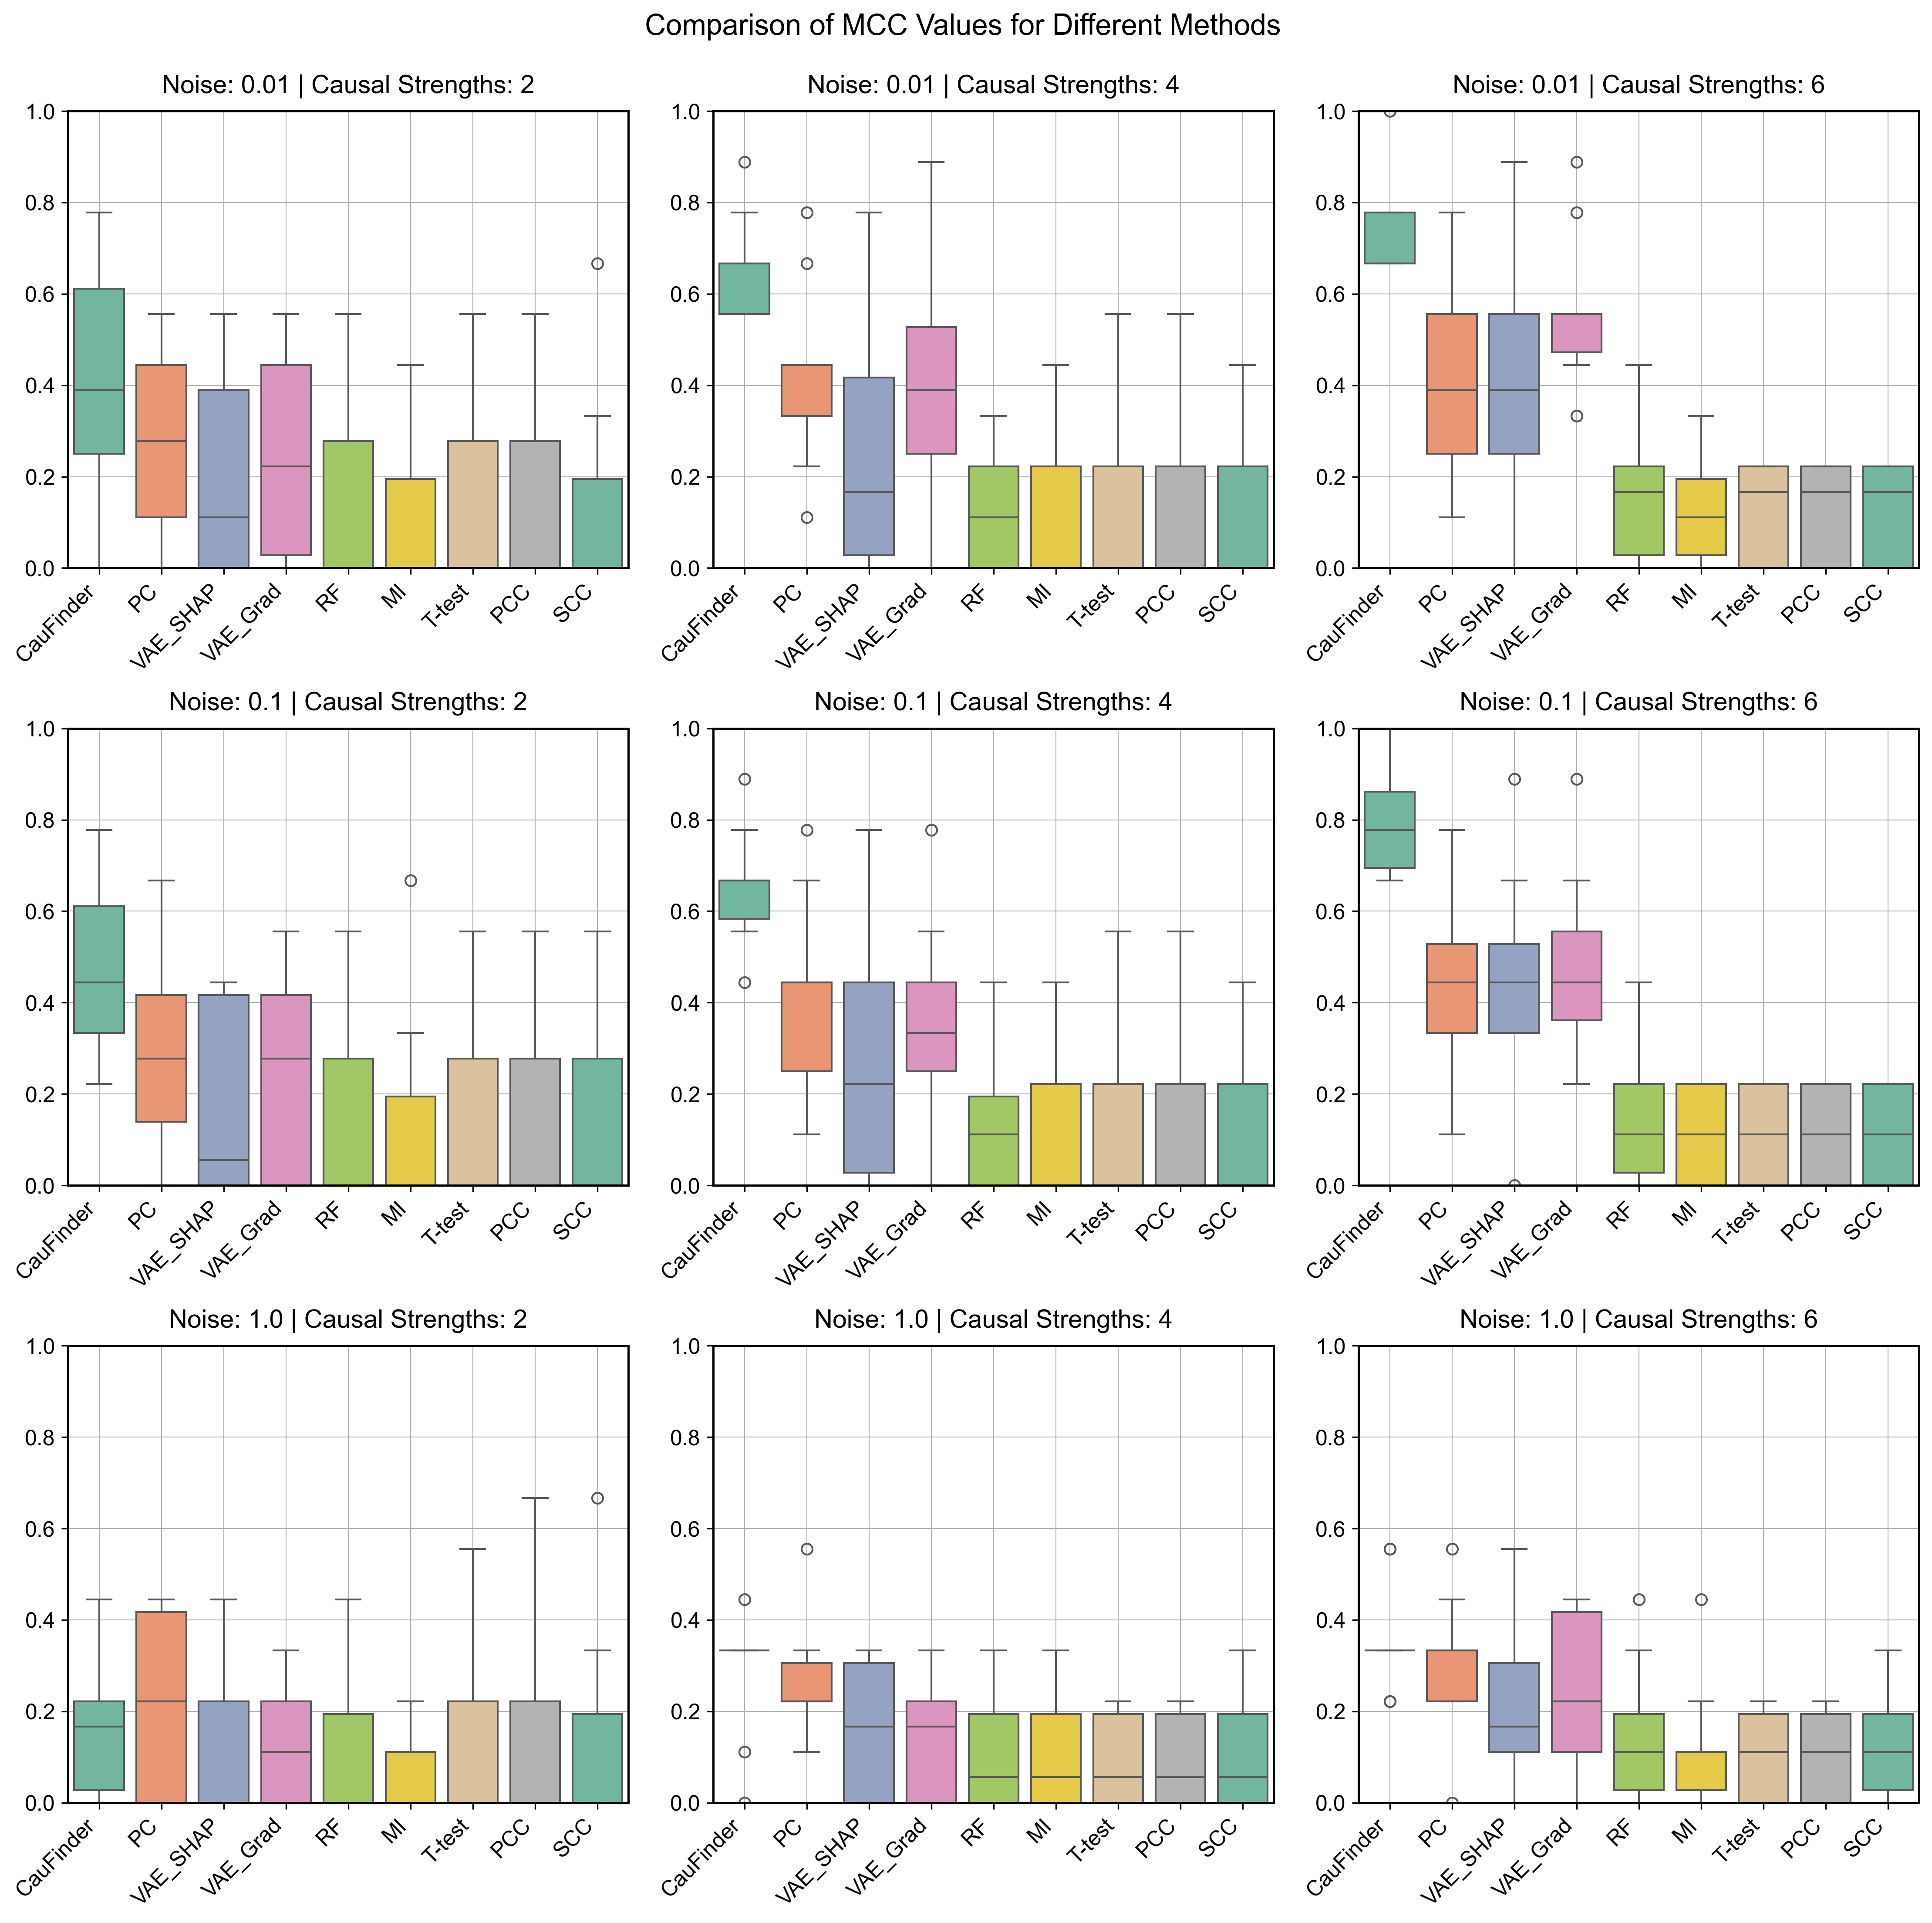

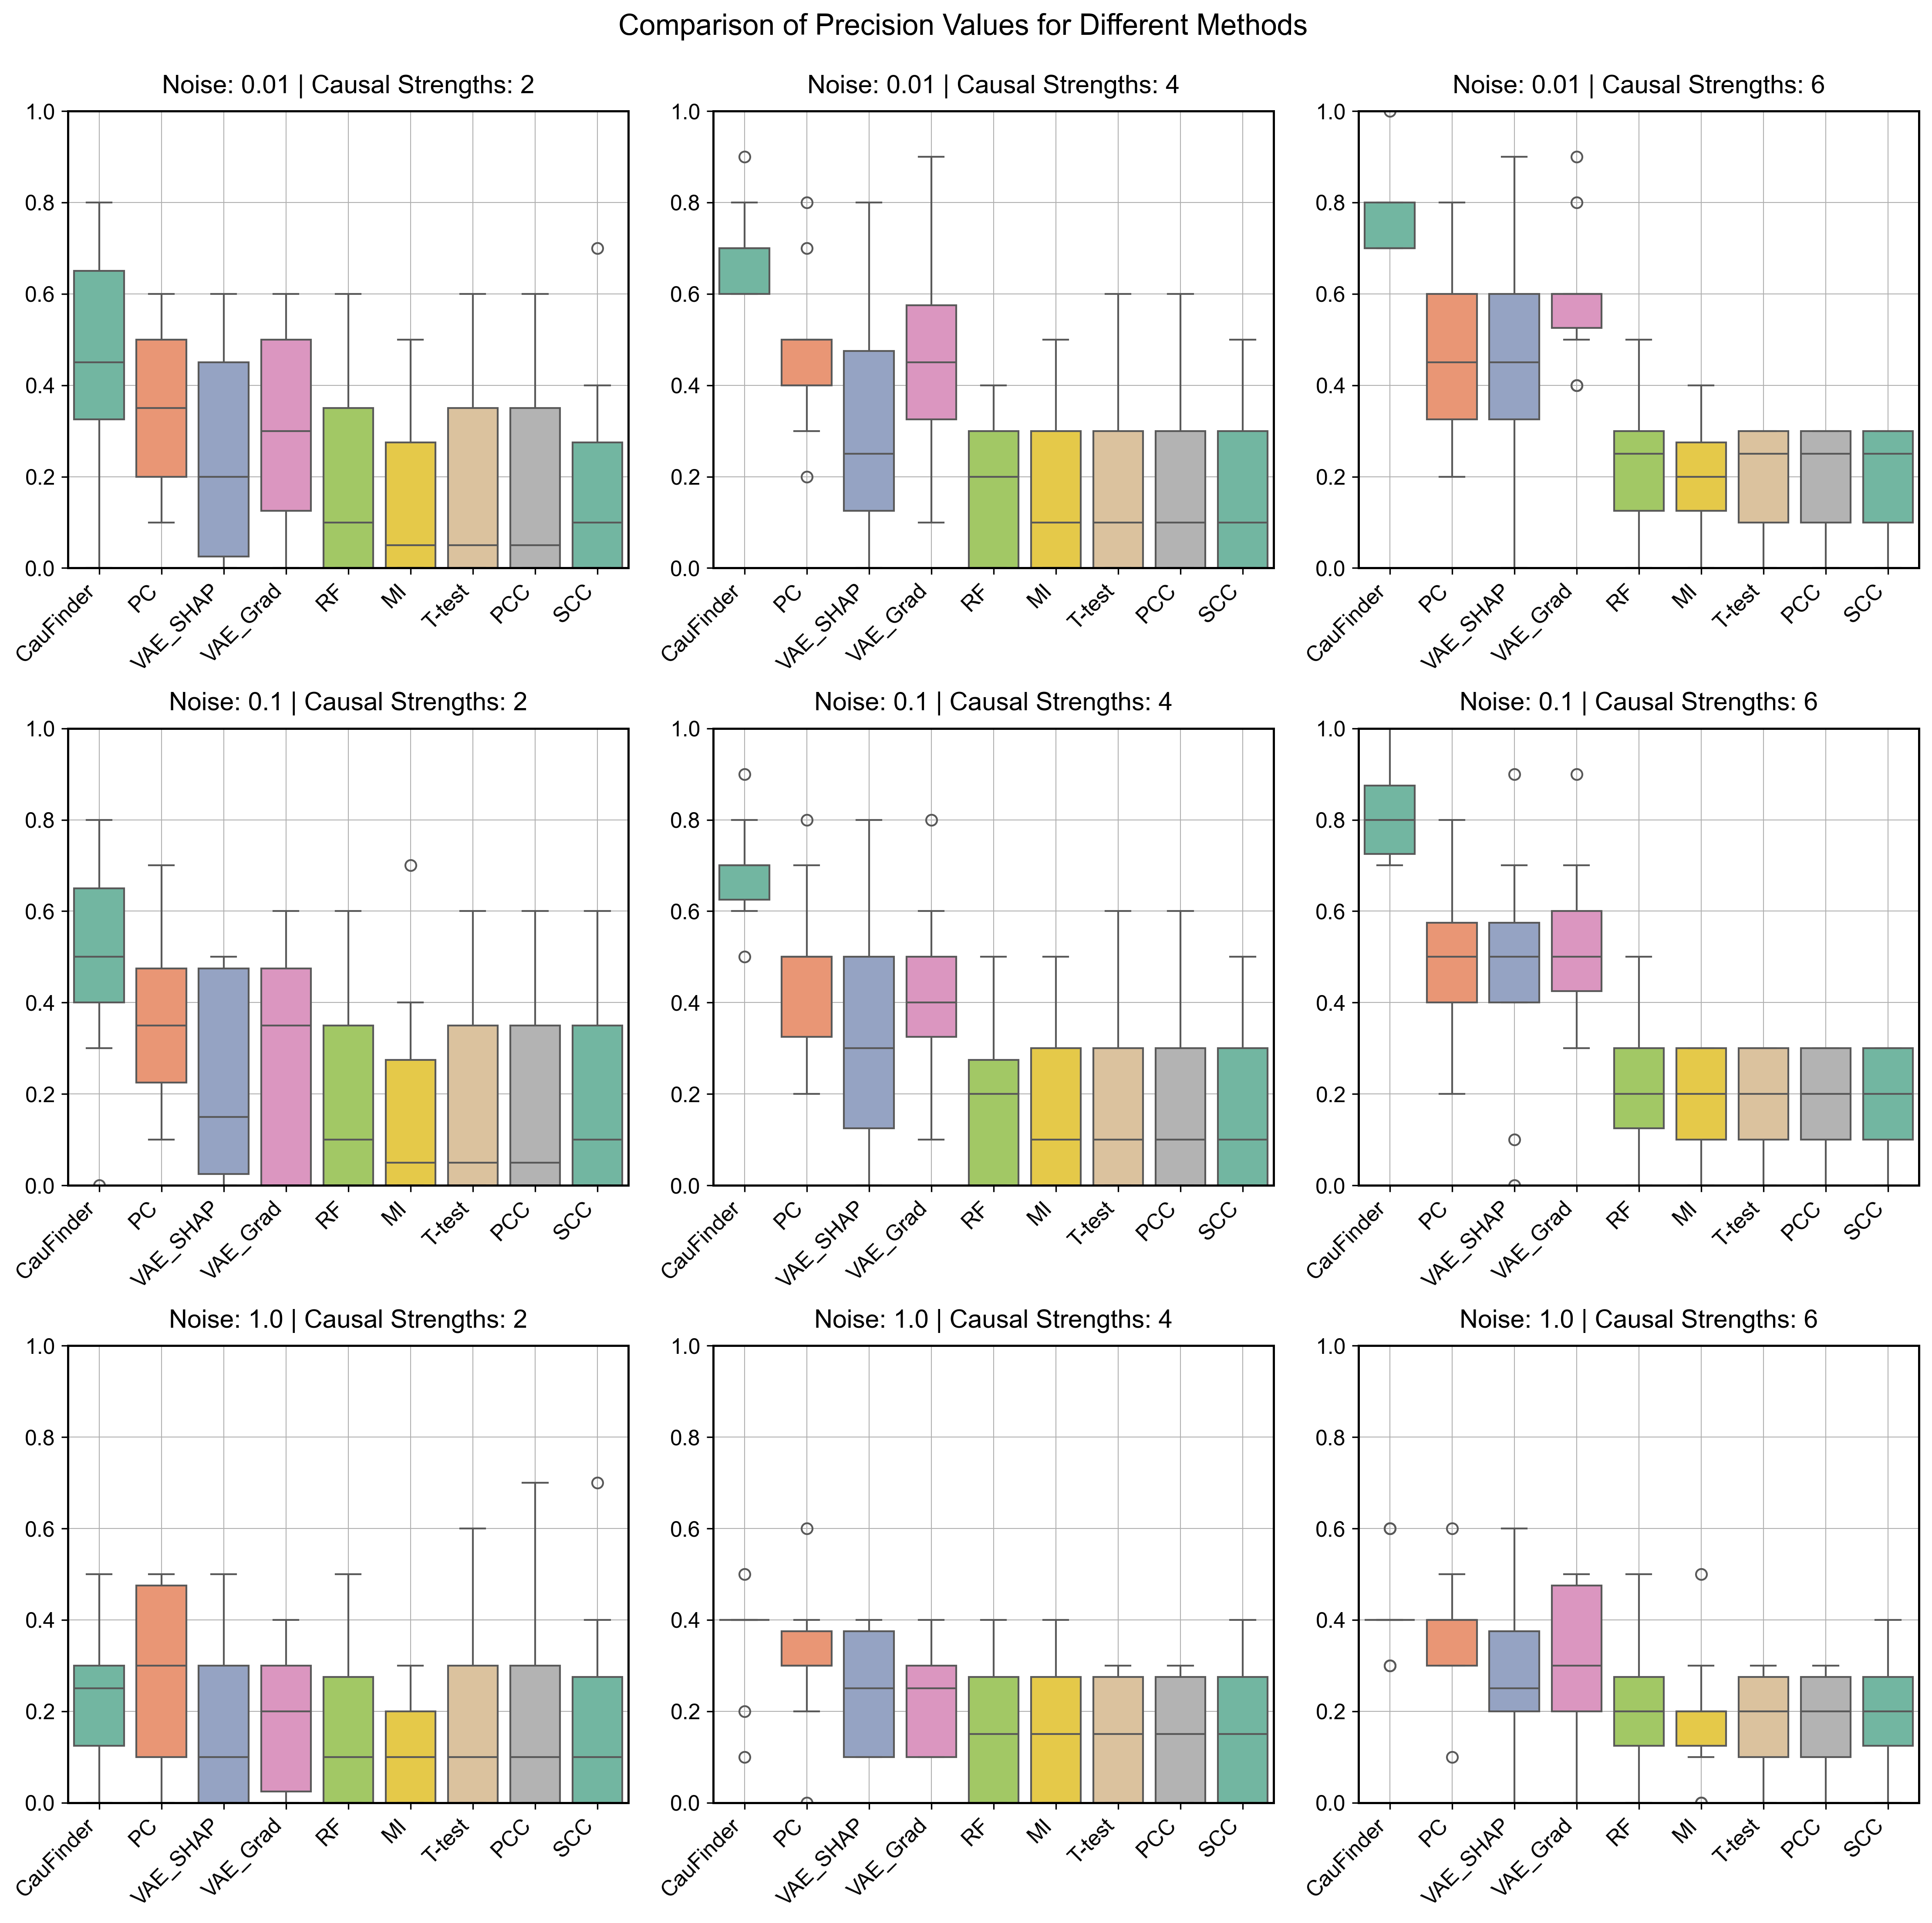

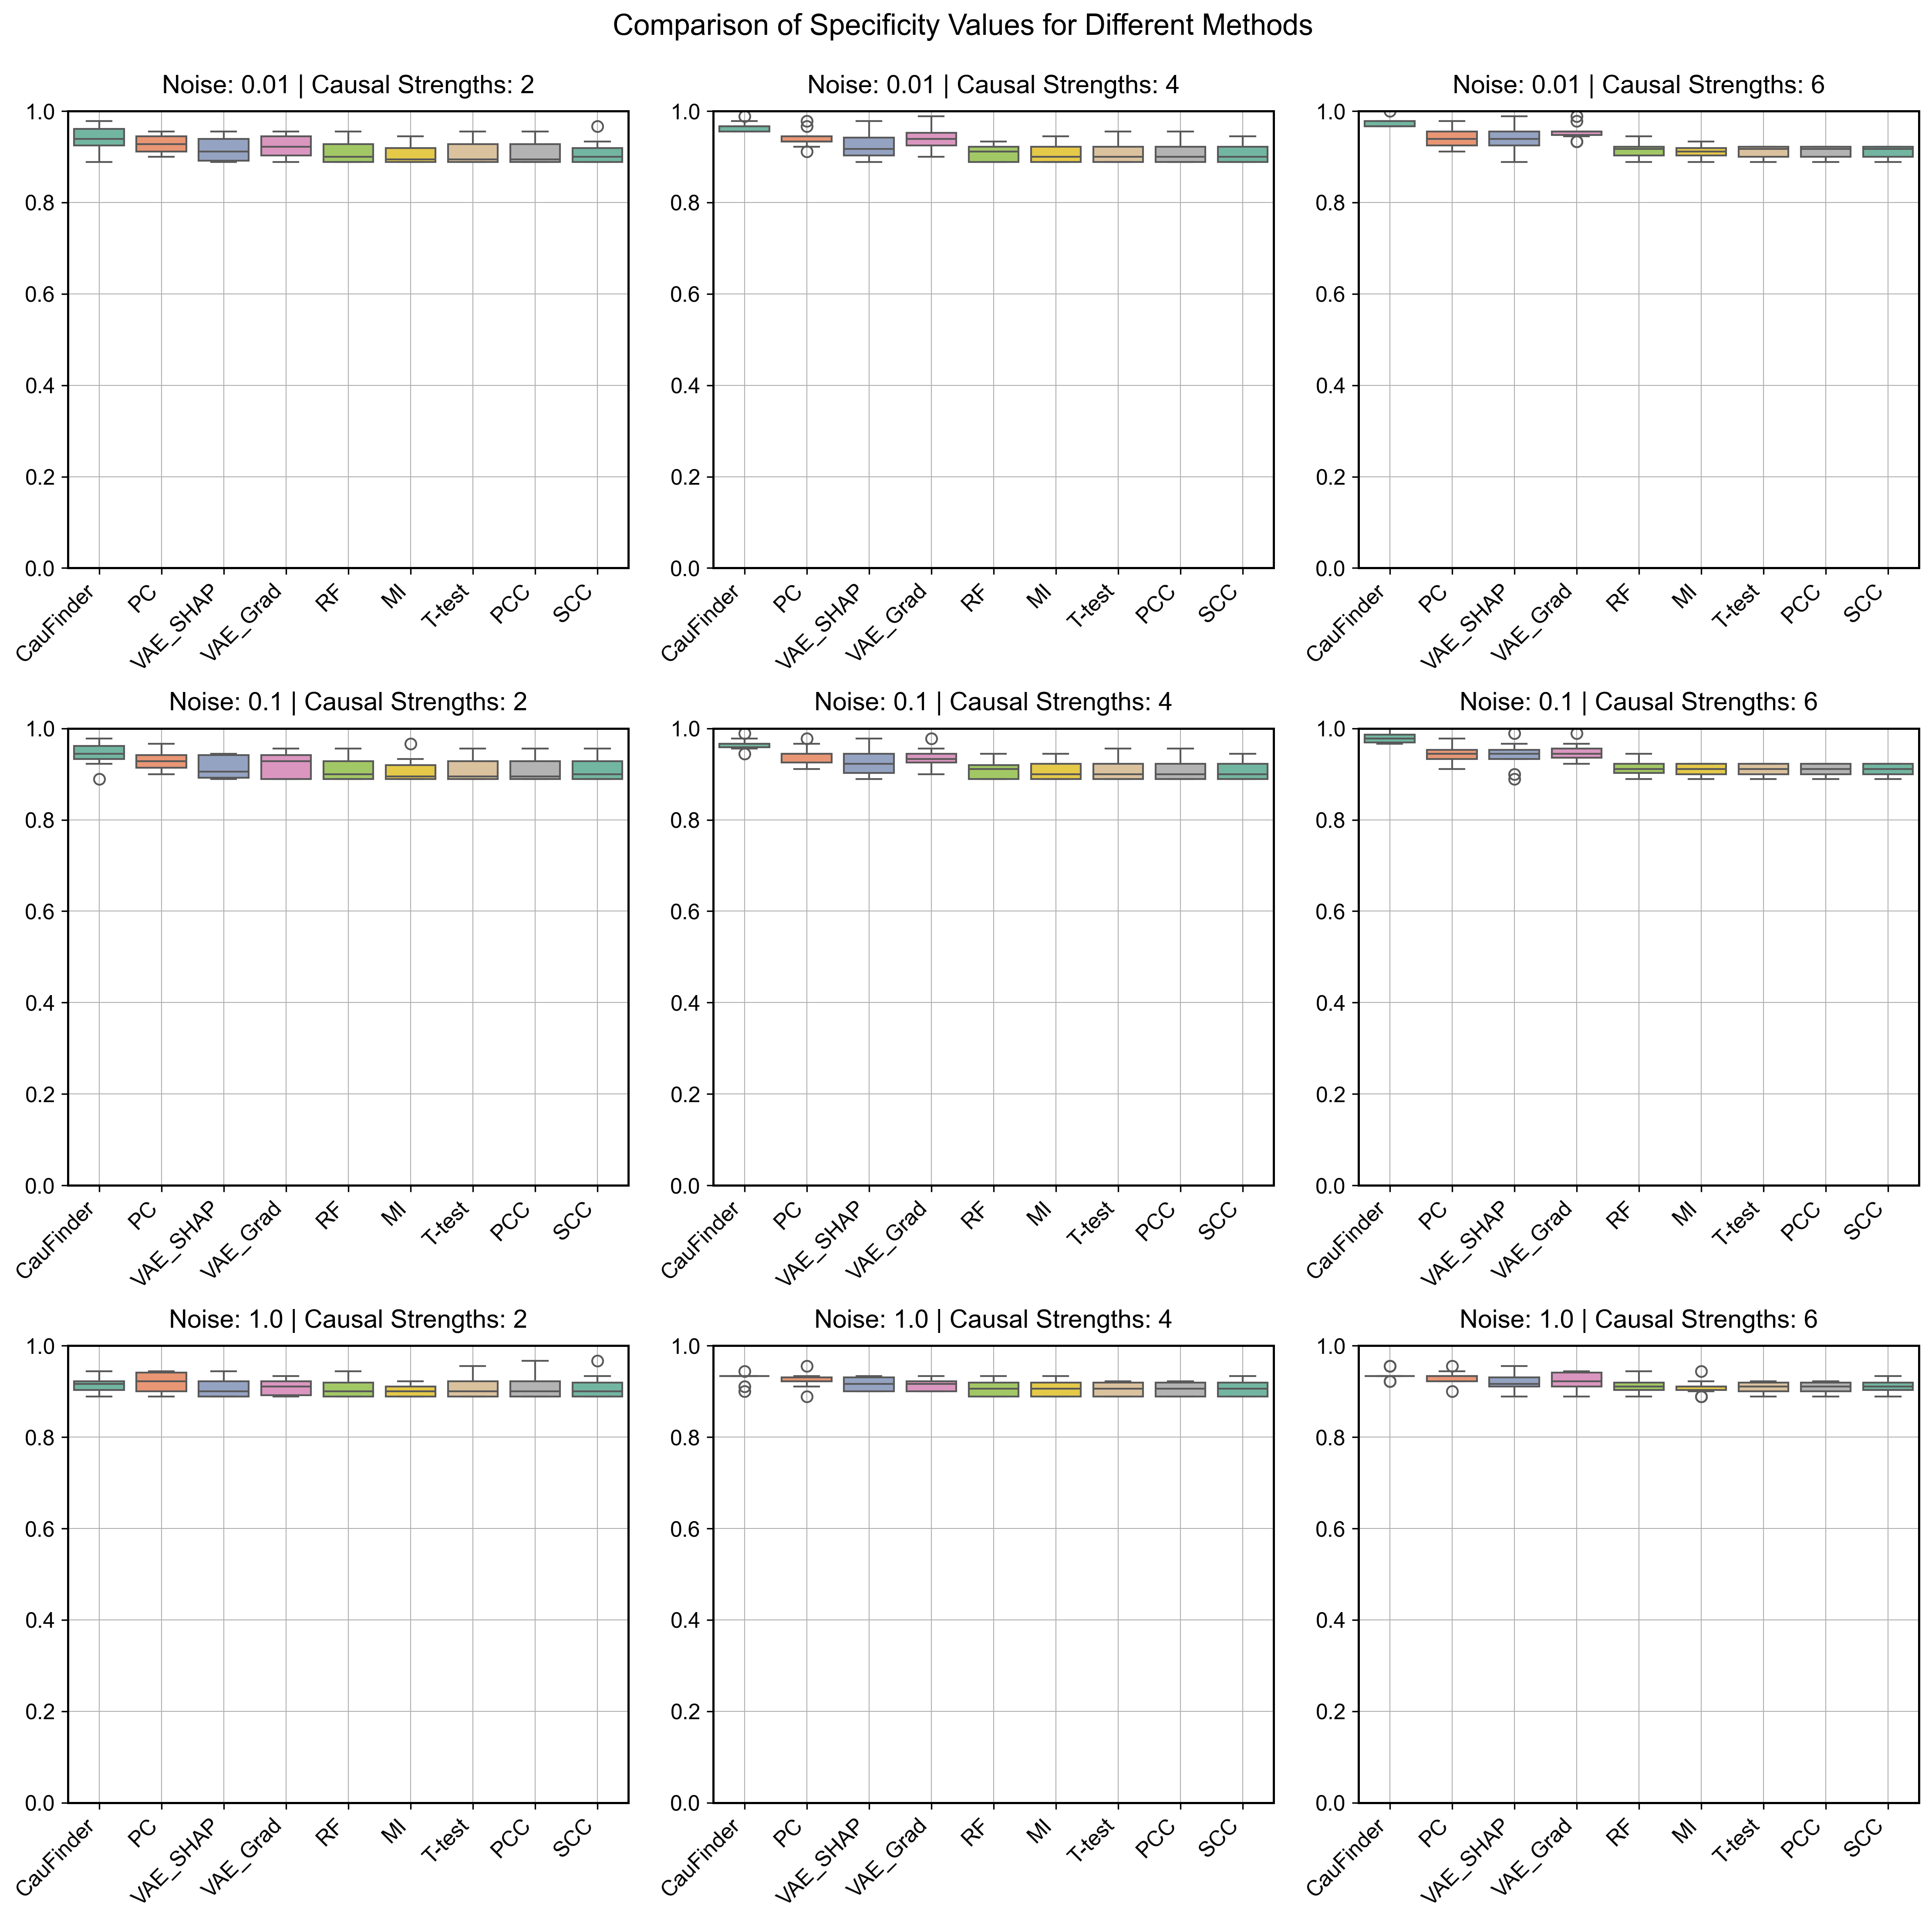

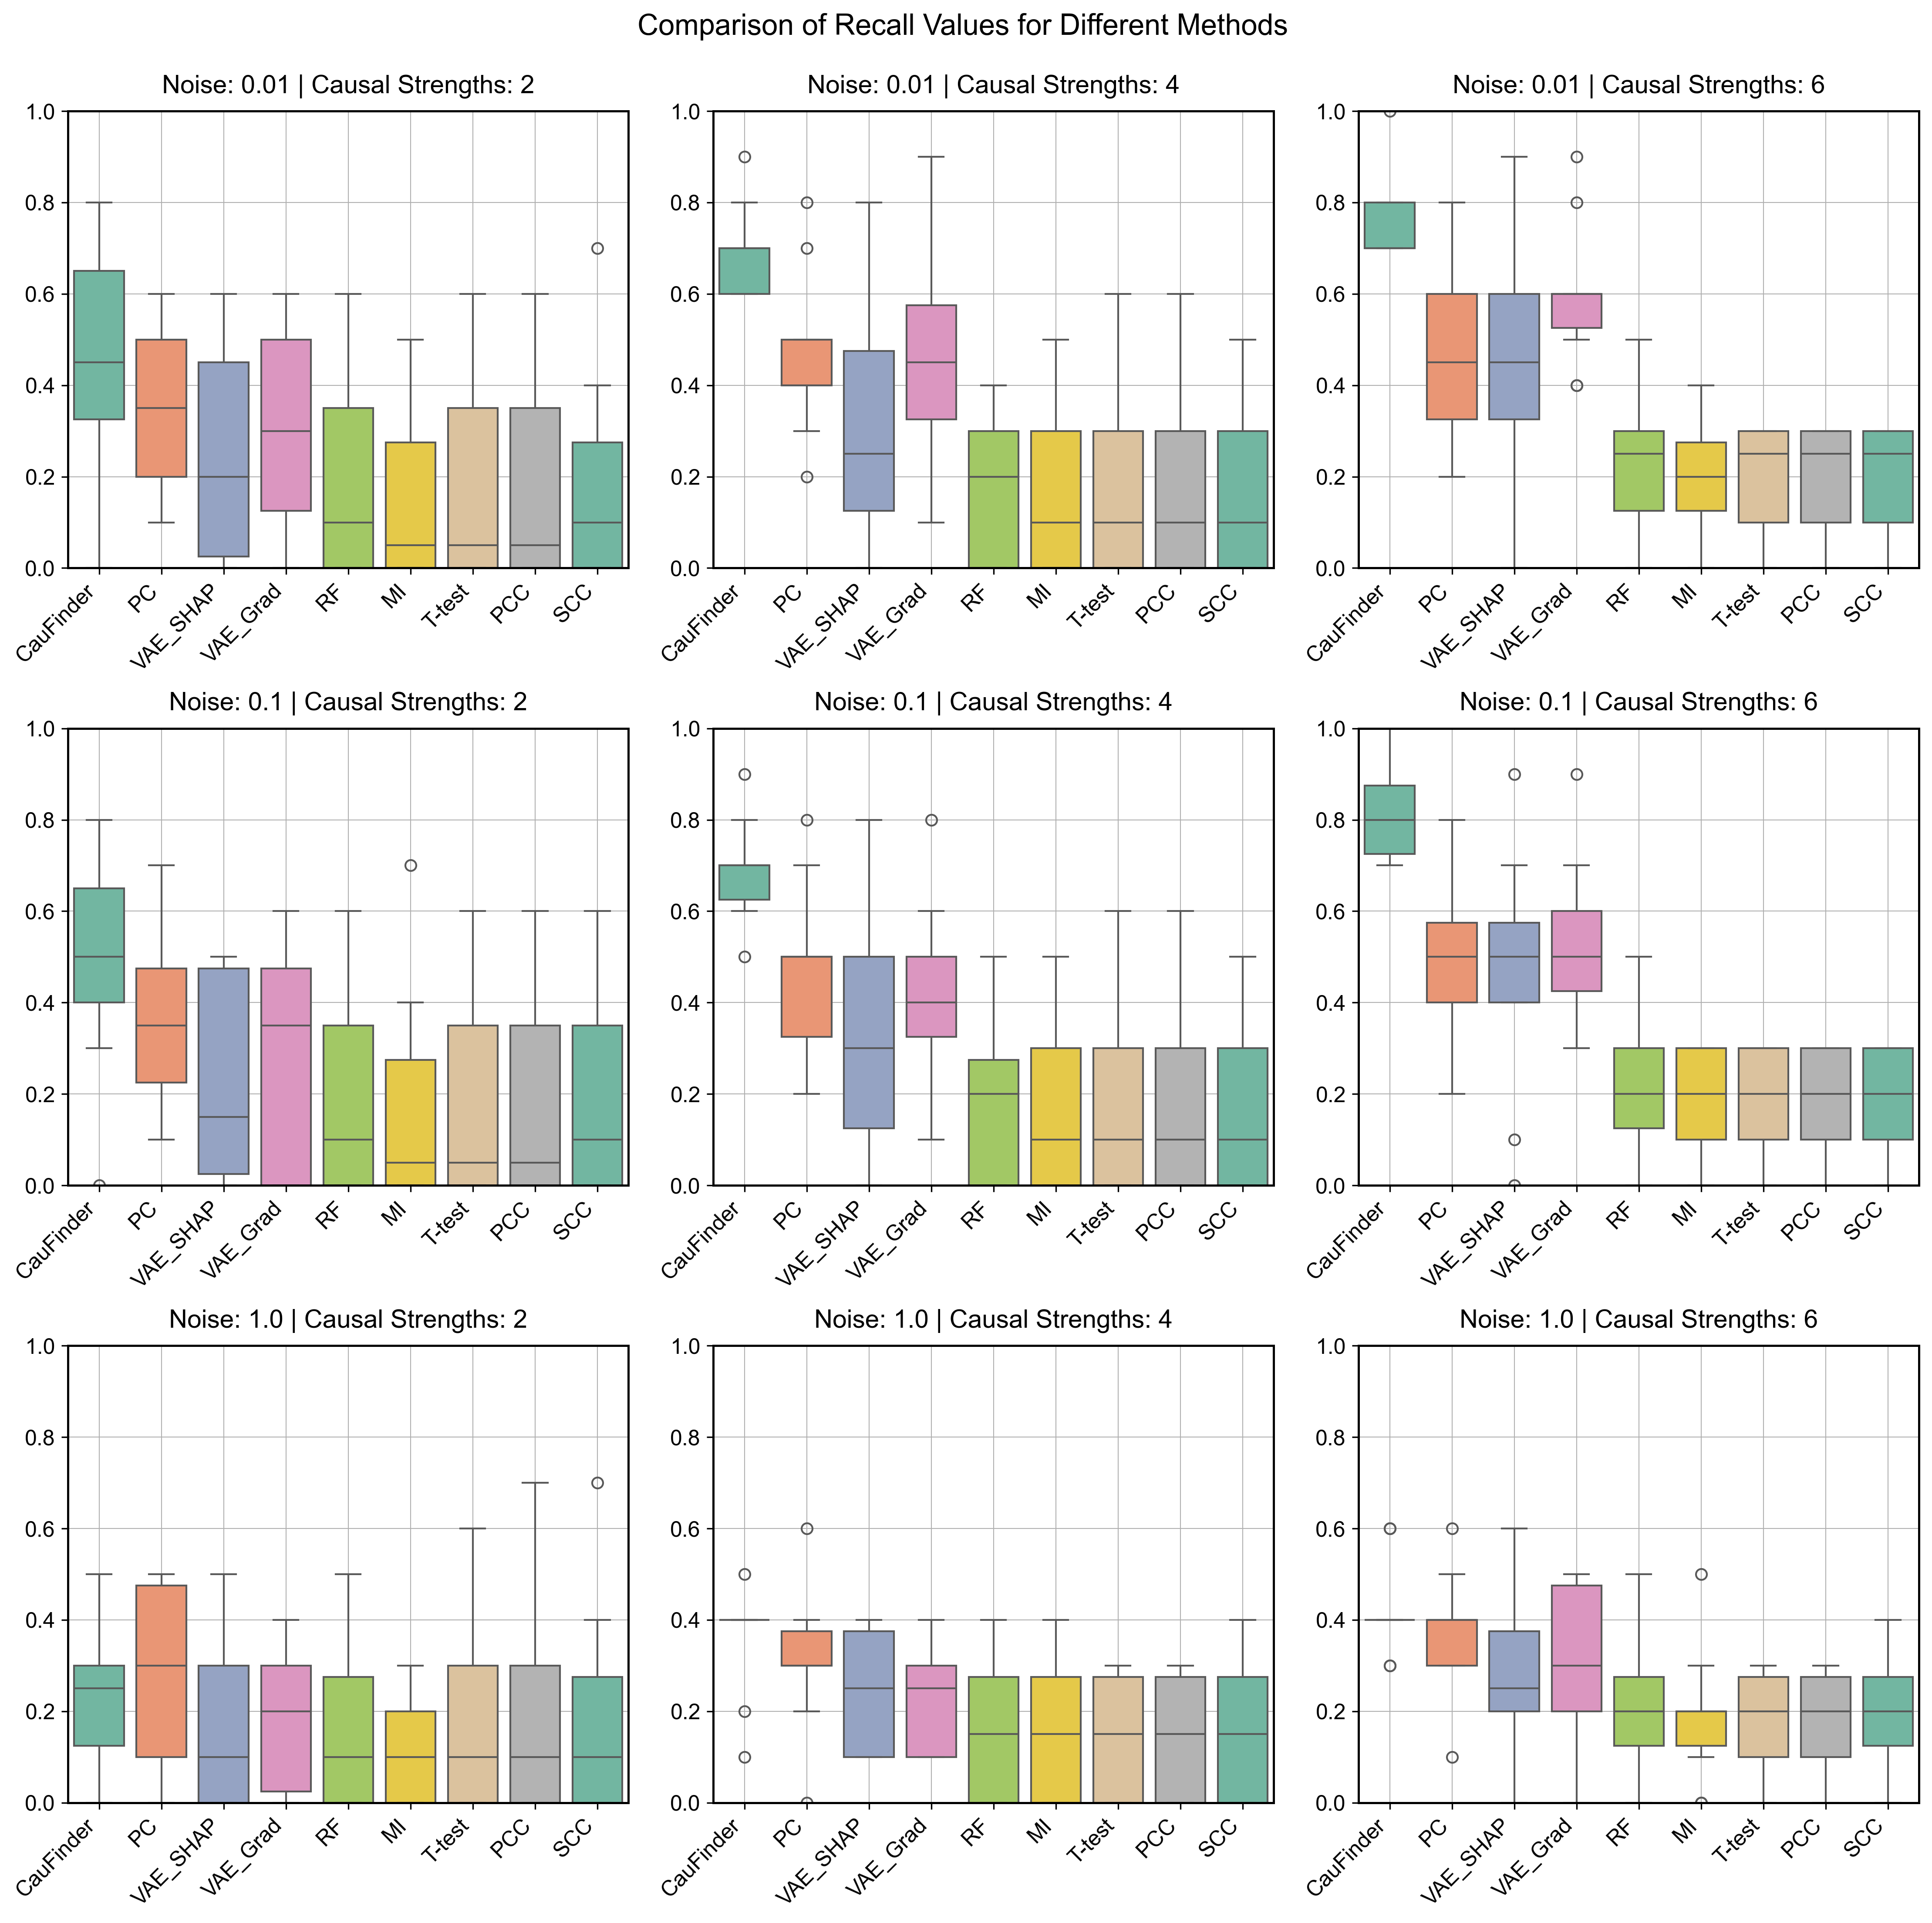

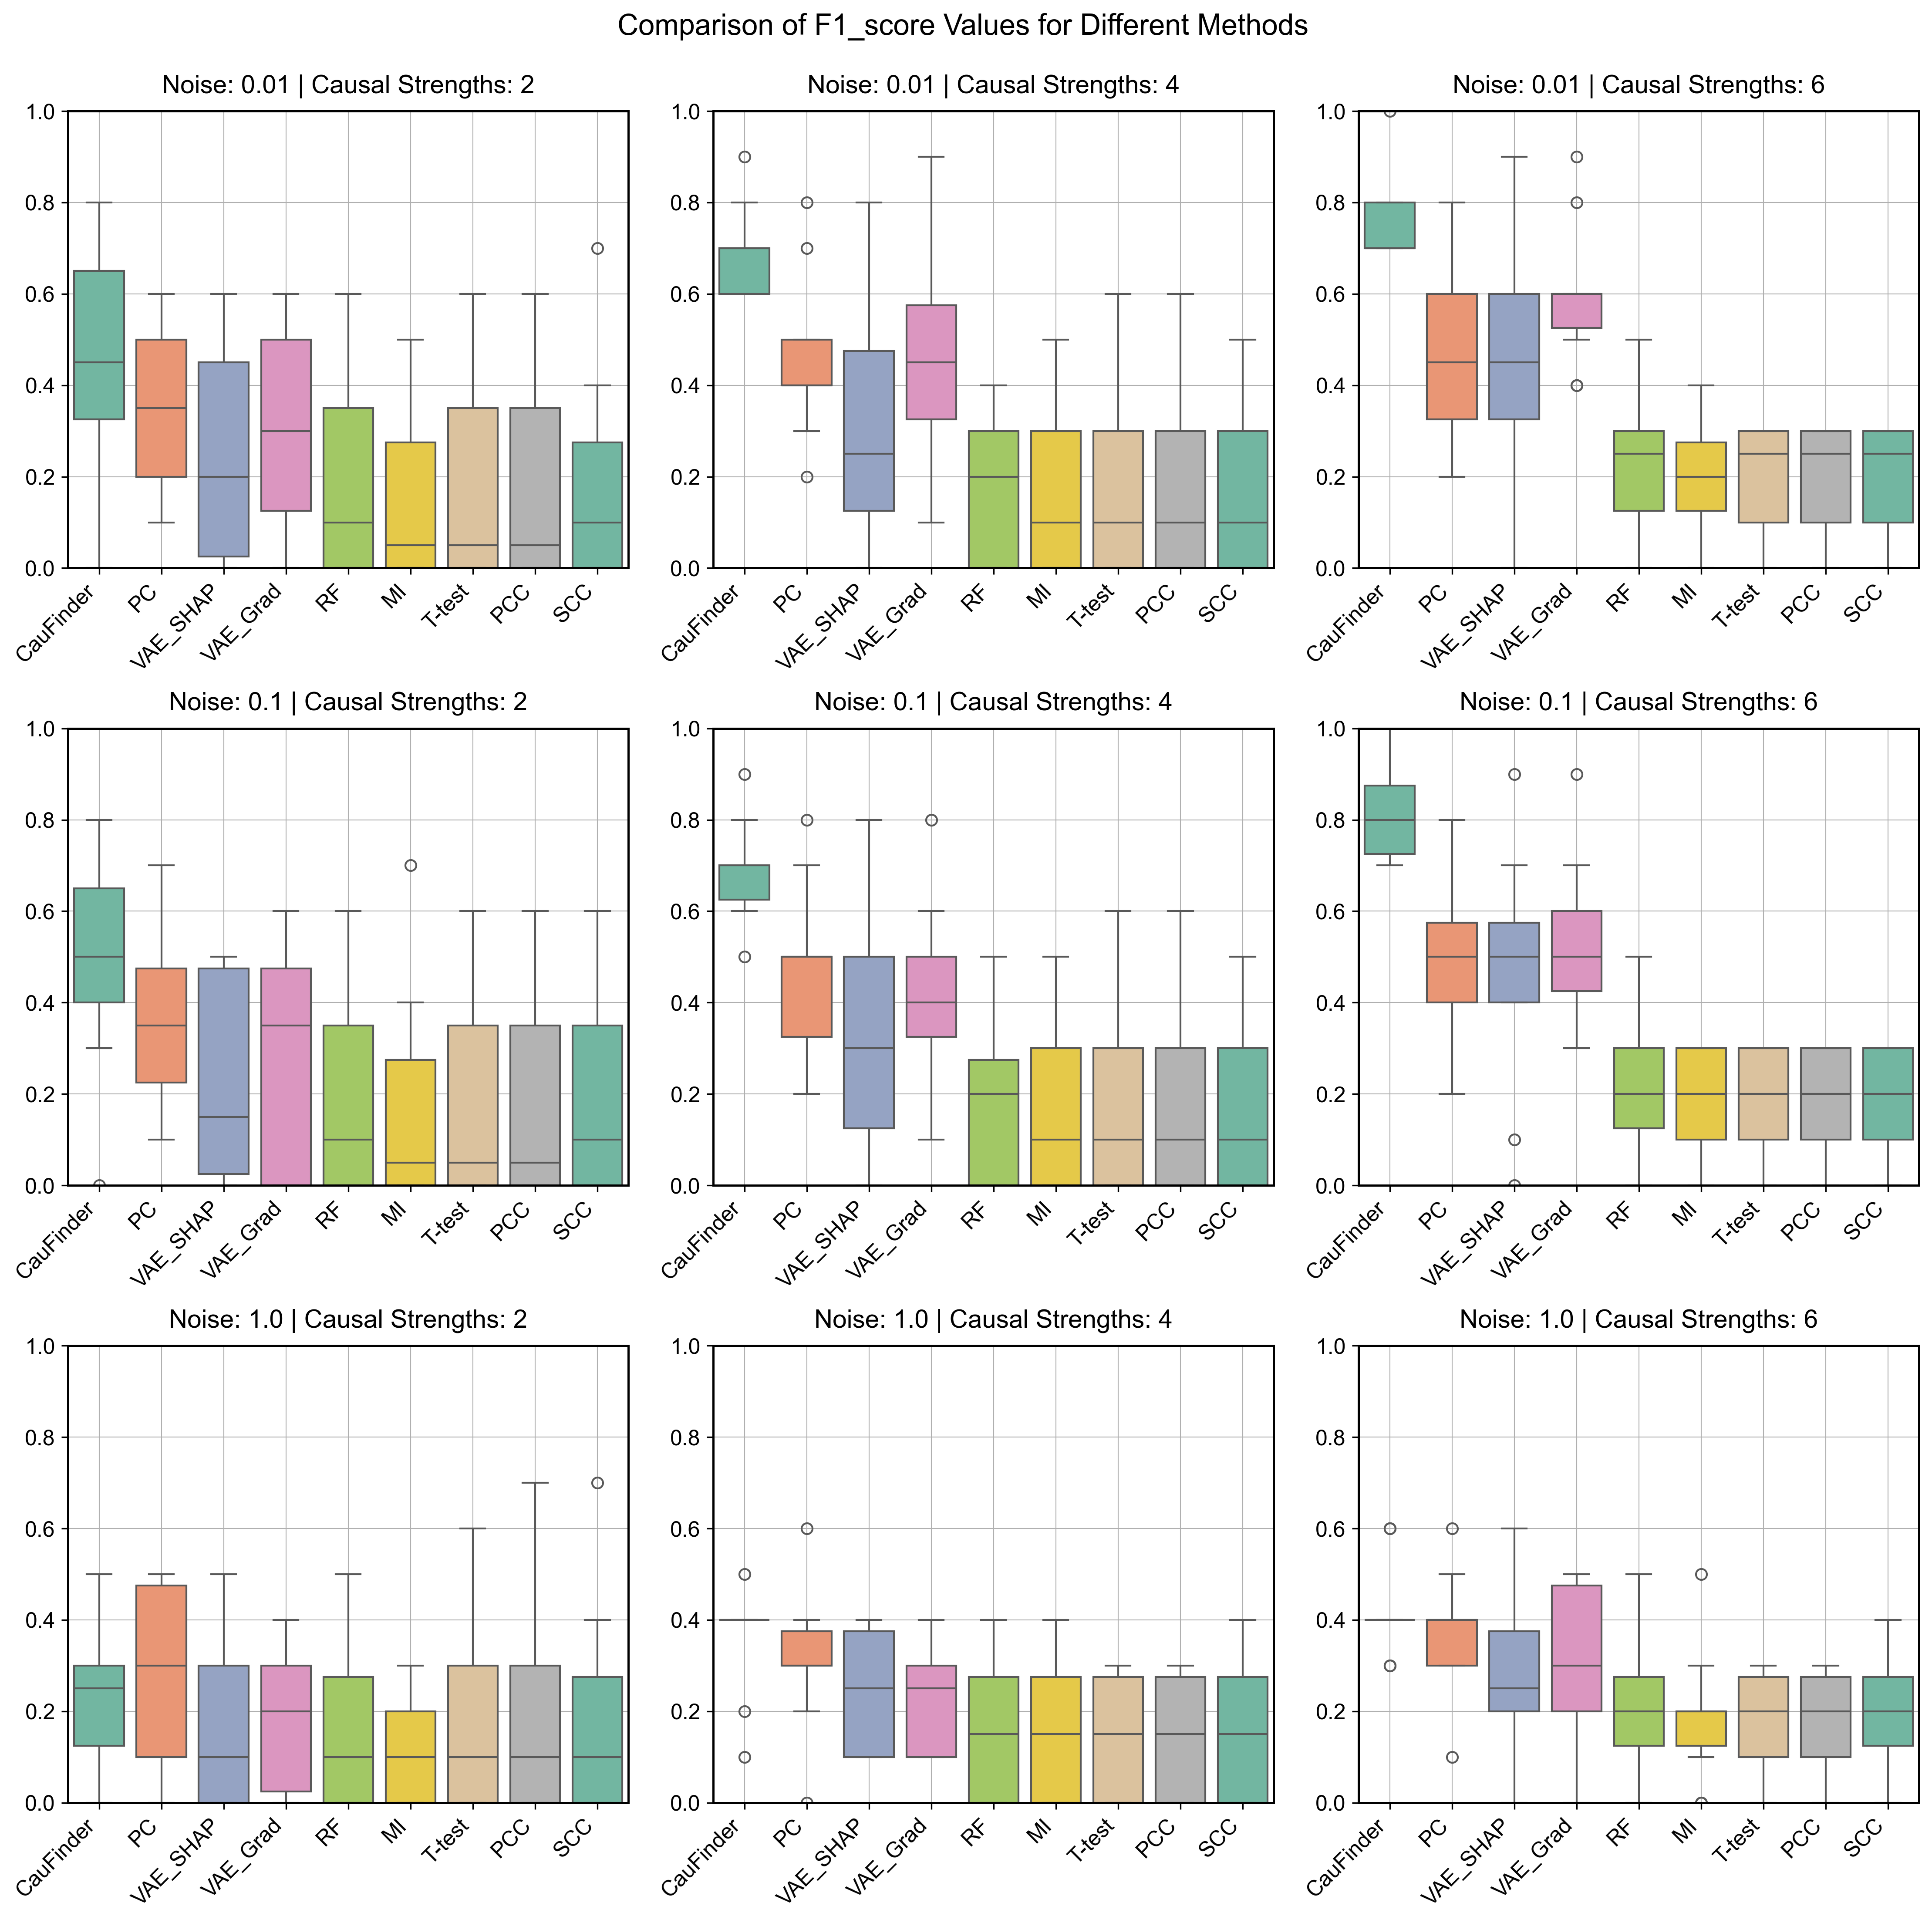

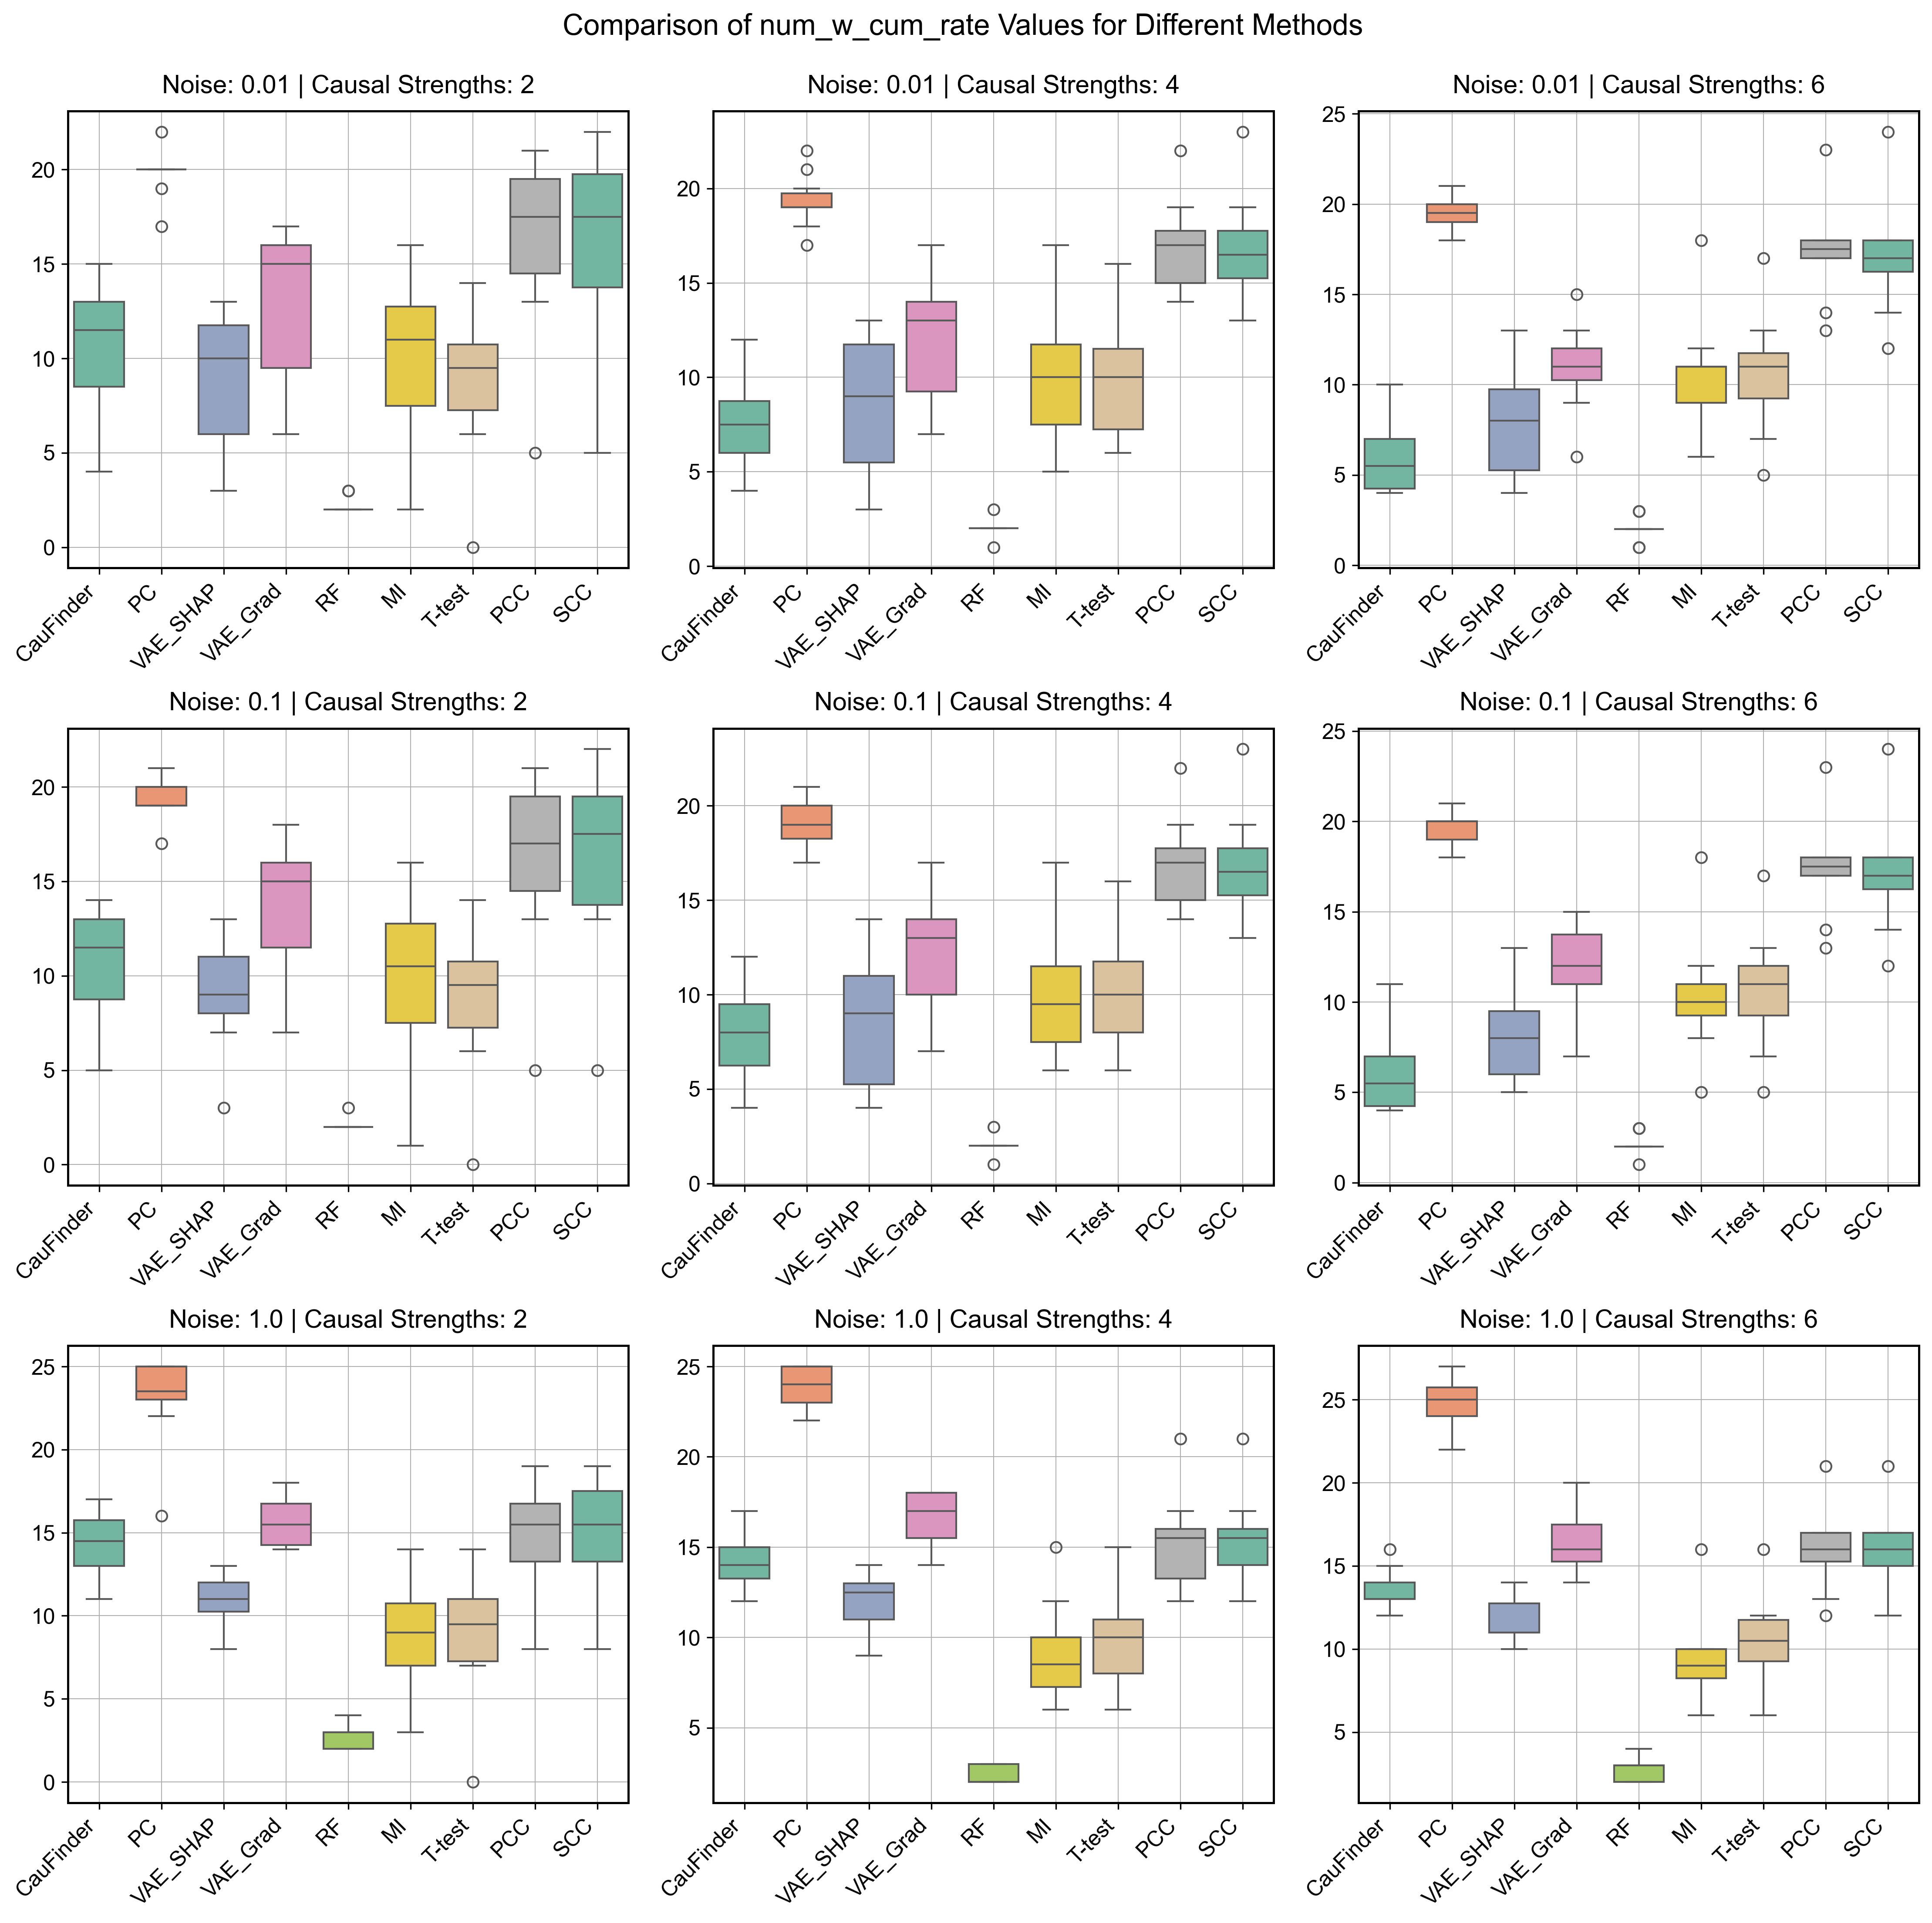

Processing metric: AUC
Processing metric: ACC
Processing metric: MCC
Processing metric: Precision
Processing metric: Specificity
Processing metric: Recall
Processing metric: F1_score
CauFinder values length: 7, num_categories: 7
Plotting CauFinder: [0.7969506172839506, 0.9091111111111112, 0.49506172839506174, 0.5455555555555556, 0.9495061728395063, 0.5455555555555556, 0.5455555555555556, 0.7969506172839506]
PC values length: 7, num_categories: 7
Plotting PC: [0.6957037037037037, 0.8784444444444444, 0.32469135802469135, 0.3922222222222222, 0.9324691358024693, 0.3922222222222222, 0.39222222222222225, 0.6957037037037037]
VAE_SHAP values length: 7, num_categories: 7
Plotting VAE_SHAP: [0.6414197530864197, 0.8604444444444446, 0.2246913580246914, 0.3022222222222222, 0.9224691358024693, 0.3022222222222222, 0.3022222222222222, 0.6414197530864197]
VAE_Grad values length: 7, num_categories: 7
Plotting VAE_Grad: [0.7033703703703704, 0.8737777777777778, 0.29876543209876544, 0.36888888888888893, 0.

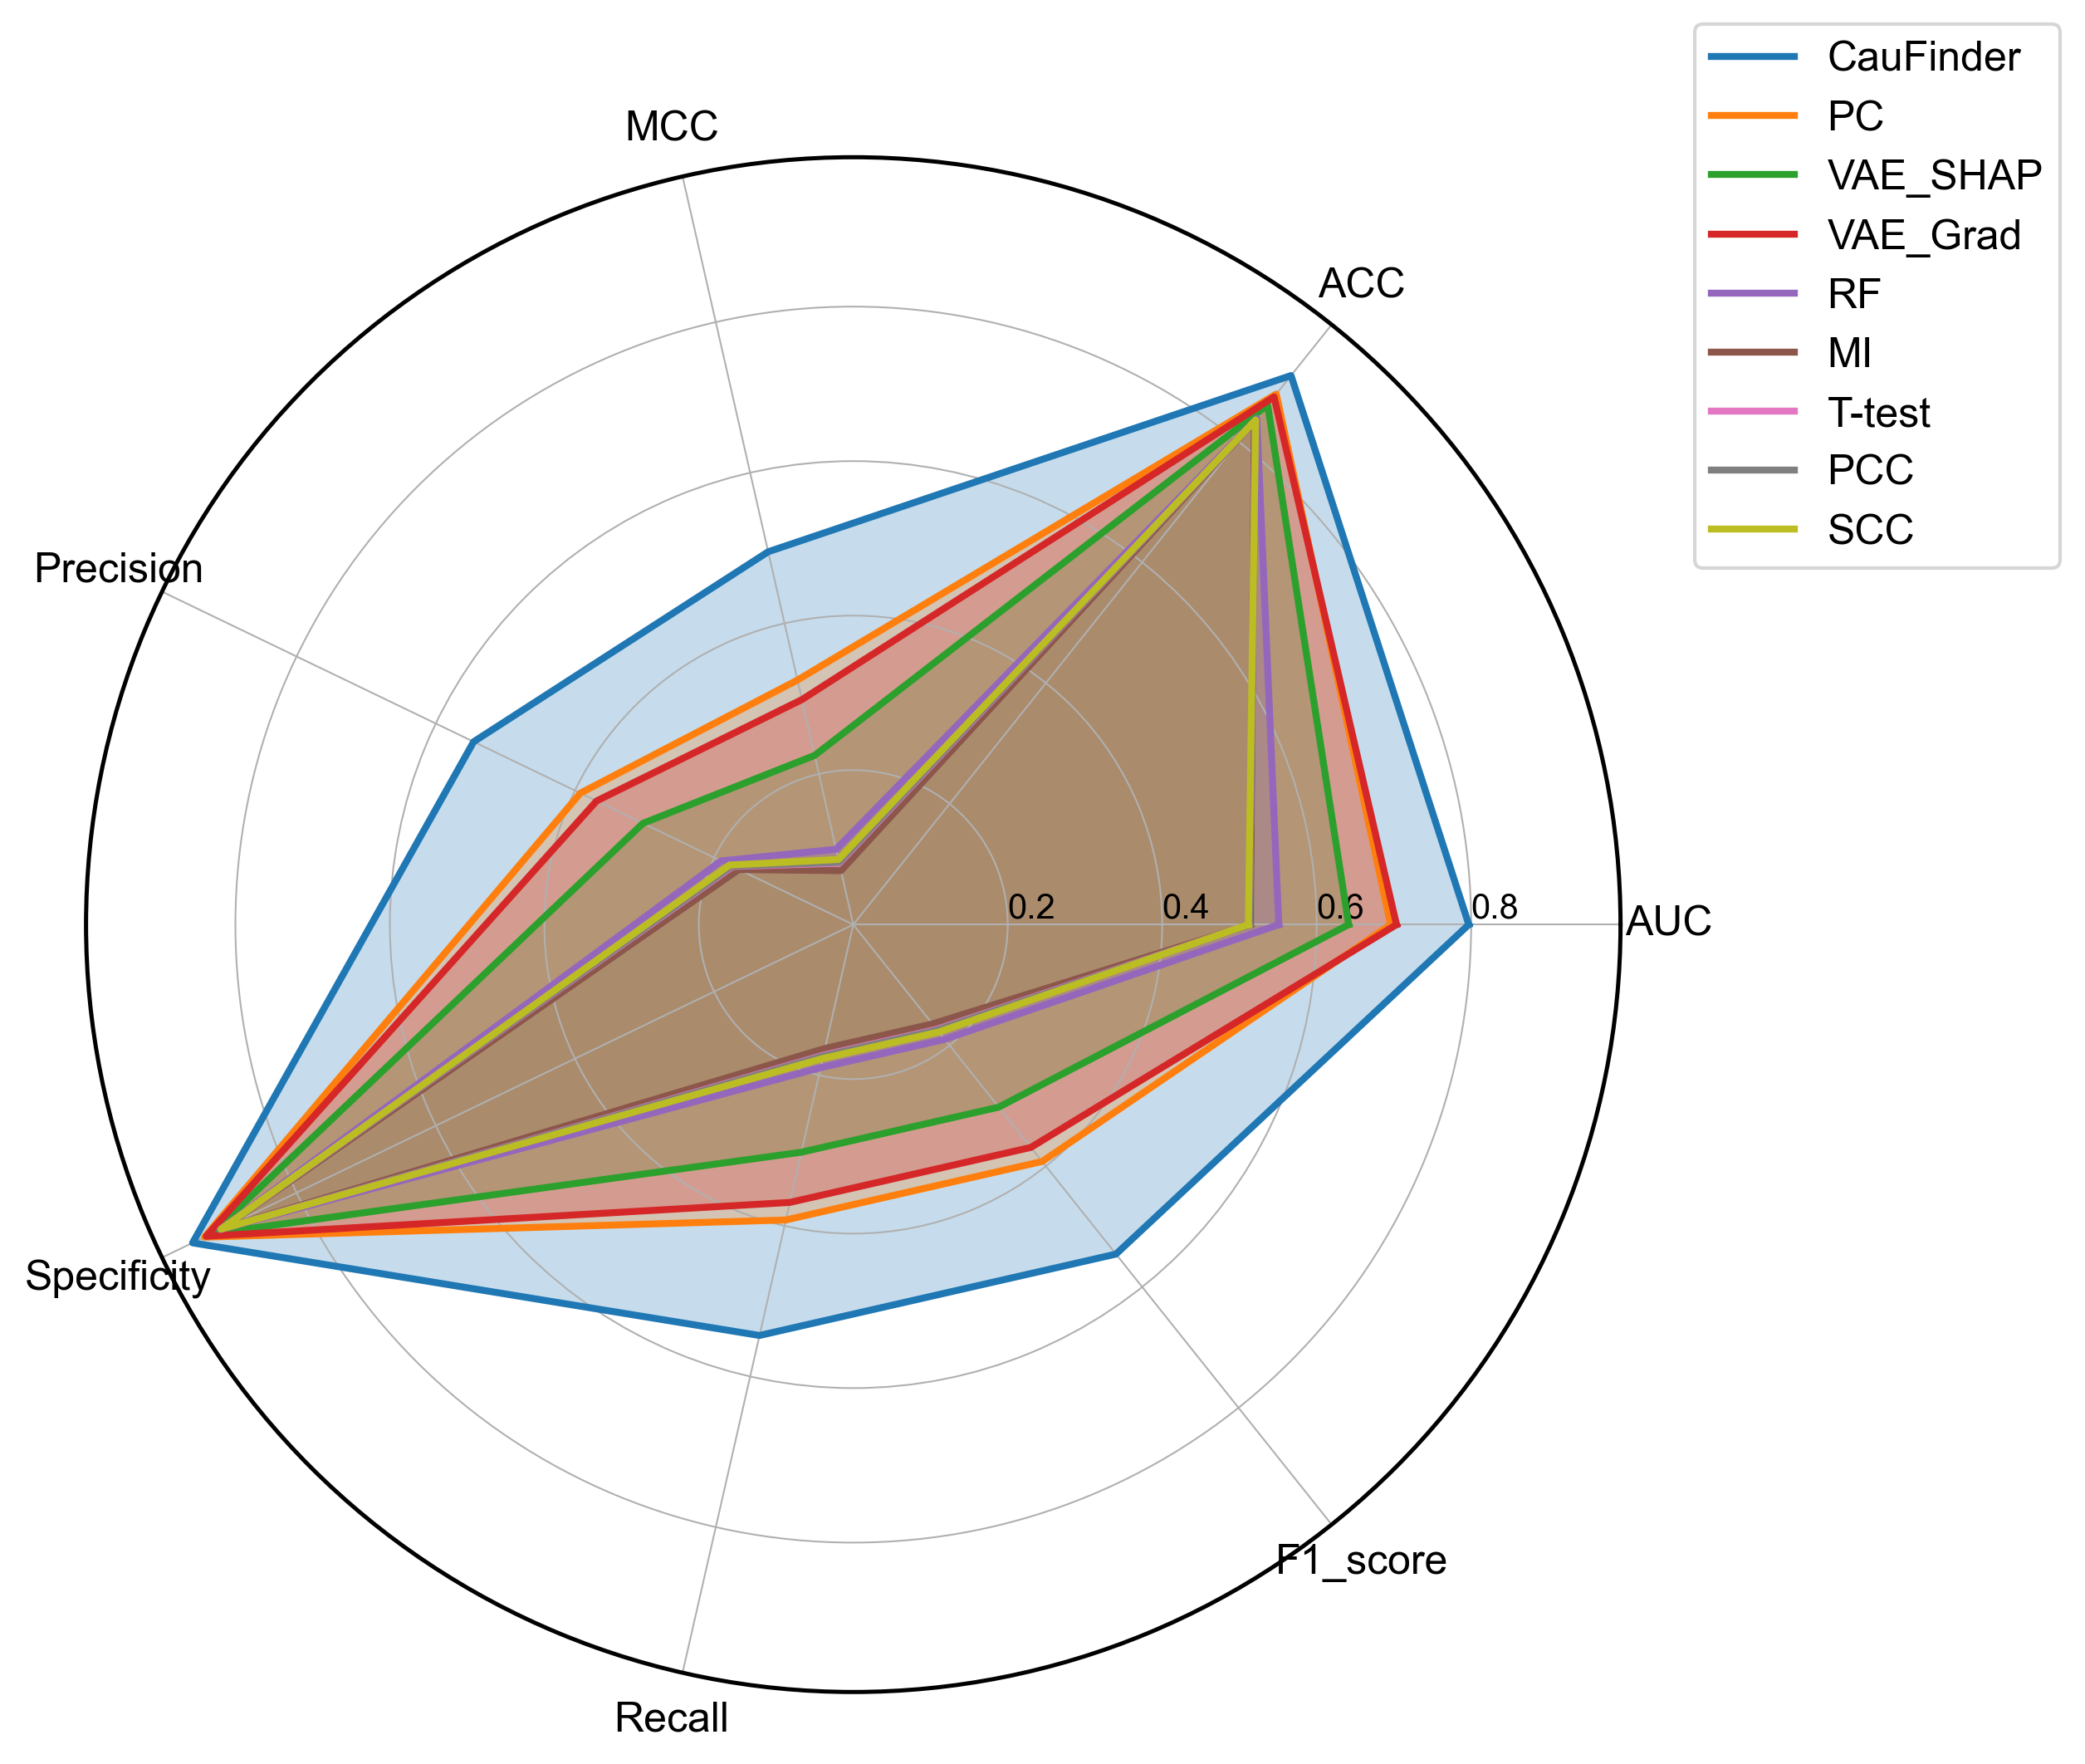

In [6]:
if __name__ == '__main__':
    # noises = [0.05, 0.1, 1.0]
    noises = [0.01, 0.1, 1.0]
    # causal_strengths = [3, 5, 8]
    # causal_strengths = [2, 5, 8]
    causal_strengths = [2, 4, 6]
    scores, results = benchmark_main(
                            noises=noises,
                            causal_strengths=causal_strengths,
                            save_path=save_path,
                            n_dataset=10,
                            is_linear=True,
                            method_for_threshold="top_k"
                        )